## Complex Networks
* This file explores complex networks (i.e. Resnet, LSTM)
* Resnet credits to: https://github.com/fanzhenya/ResNet1D-VariableLengthPooling-For-TimeSeries

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, models, transforms
#from sklearn.metrics import precision_recall_curve

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))
lambda_val = 1.5

In [3]:
# Biological features
# kd hydrophobicity scale
hydrophobicity = {'G': -0.4, 'A': 1.8, 'L':3.8, 'M': 1.9, 'F':2.8, 'W':-0.9, 'K':-3.9, 'Q':-3.5, 'E':-3.5, 'S':-0.8, 'P':-1.6, 'V':4.2, 'I':4.5, 'C':2.5, 'Y':-1.3, 'H':-3.2, 'R':-4.5, 'N':-3.5, 'D':-3.5, 'T':-0.7}
# Ranked
polarity = {'A': 0.45, 'R': 0.75, 'N': 0.8, 'D': 0.95, 'C':0.35, 'Q': 0.85, 'E': 0.90, 'G': 0.55, 'H': 0.5, 'I': 0.05, 'L': 0.15, 'K': 1, 'M': 0.25, 'F': 0.1, 'P': 0.65, 'S': 0.7, 'T': 0.6, 'W': 0.3, 'Y': 0.4, 'V': 0.2}
# Van der waal's volume
volume = {'A': 67, 'R': 148, 'N': 96, 'D': 91, 'C':86, 'Q': 114, 'E': 109, 'G': 48, 'H': 118, 'I': 124, 'L': 124, 'K': 135, 'M': 124, 'F': 135, 'P': 90, 'S': 73, 'T': 93, 'W':163, 'Y':141, 'V': 105}

# TODO: branched, hydrophilic, hydrophobic, shape
charge = {'A': 2, 'R': 3, 'N': 2, 'D': 1, 'C': 2, 'E':1, 'Q':2, 'G':2, 'H': 3, 'I':2, 'L': 2, 'K': 3, 'M':2, 'F':2, 'P':2, 'S':2, 'T': 2, 'W':2, 'Y': 2, 'V':2 }

# Normalize all of the biological features:
# Charge
for k,v in charge.items():
    if v == 1:
        charge[k] = 0
    elif v == 2:
        charge[k] = 0.5
    else:
        charge[k] = 1.0

# Volume
for k,v in volume.items():
    volume[k] = v/163.0

#Polarity
min_v = -4.5
max_v = 4.5
for k,v in hydrophobicity.items():
    hydrophobicity[k] = (v - min_v)/(max_v - min_v)    

In [4]:
# Experiment with the blosum62 matrix
blosum62 = {}
with open('blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        blosum62[aa] = encoding

## Dataset

In [5]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [6]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [7]:
binary_ds=BinaryDataset(filepath="../data/higher_quality_thresholded.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

## NN Model

In [8]:
# Expects aptamer directly translated
# Expects peptides with 4 biological features (hydrophobicity, polarity, volume, charge)
class BioNet(nn.Module):
    def __init__(self):
        super(BioNet, self).__init__()
        self.name = "BioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 5, 1, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(35, 20)
        self.fc2 = nn.Linear(20, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Expects aptamers directly translated
# Expects peptides directly translated + 4 biological features (hydrophobicity, polarity, volume, charge)
class TranslateBioNet(nn.Module):
    def __init__(self):
        super(TranslateBioNet, self).__init__()
        self.name = "TranslateBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(5, 30, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(30, 75, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(75, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 250, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(250, 100, 3, padding=2)
        self.cnn_pep_6 = nn.Conv1d(100, 50, 3, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu,
                                     self.cnn_pep_3, self.maxpool, self.relu,
                                     self.cnn_pep_4, self.maxpool, self.relu,
                                     self.cnn_pep_5, self.maxpool, self.relu,
                                     self.cnn_pep_6, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(115, 50)
        self.fc2 = nn.Linear(50, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

# Expects aptamers directly translated
# Expects 4 biological features (hydrophobicity, polarity, volume, charge)
class ComplexBioNet(nn.Module):
    def __init__(self):
        super(ComplexBioNet, self).__init__()
        self.name = "ComplexBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 5, 1, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(35, 15)
        self.fc2 = nn.Linear(15, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x



In [9]:
# Expects aptamer one-hot encoded
# Expects peptides with 4 biological features (hydrophobicity, polarity, volume, charge)
class OHBioNet(nn.Module):
    def __init__(self):
        super(OHBioNet, self).__init__()
        self.name = "OHBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 30, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(30, 10, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 5, 1, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(35, 20)
        self.fc2 = nn.Linear(20, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [10]:
# Expects aptamers directly translated
# Expects 4 biological features (hydrophobicity, polarity, volume, charge)
class LinearBioNet(nn.Module):
    def __init__(self):
        super(LinearBioNet, self).__init__()
        self.name = "LinearBioNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 20, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(20, 10, 3, padding=2) 
        
        self.cnn_pep_1 = nn.Conv1d(4, 10, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(10, 7, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(131, 100)
        self.fc2 = nn.Linear(100, 75)
        self.fc3 = nn.Linear(75, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [11]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be directly translated
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(1, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(210, 100)
        self.fc2 = nn.Linear(100, 75)
        self.fc3 = nn.Linear(75, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [13]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
    
## For aptamer sequence, translate
## For peptide sequence, translate and add additional biological properties
def extract_features(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            letters = aa_list
            encoding = np.zeros((4, len(sequence)))
            for i in range(len(sequence)):
                char = sequence[i]
                
                idx = letters.index(char)
                char_hydro = hydrophobicity[char]
                char_polar = polarity[char]
                char_vol = volume[char]
                char_charge = charge[char]
                
                # Put in the biological features of the amino acids
                encoding[0][i] = char_polar
                encoding[1][i] = char_vol
                encoding[2][i] = char_charge
                encoding[3][i] = char_hydro
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                encoding.append(blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True) #(2, 40)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') 
        pep = blosum62_encoding(pep, seq_type='peptide') 
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[1], apt.shape[0]))).to(device)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[1], pep.shape[0]))).to(device) 
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Nonbinding Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Nonbinding Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Binding Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Binding Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def auc_cdf(train, new, model_name, model_id, val=False): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    if val:
        plt.title("Validation CDF")
    else:
        plt.title("Train CDF")
    plt.xlim([0,1])
    if val:
        plt.savefig('plots/binary/%s/%s/val_cdf.png' % (model_name, model_id), bbox_inches='tight')
    else:
        plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()
    plt.close()
    return np.trapz(y, gamma)

## Binary Classification

In [14]:
if device == torch.cuda:
    torch.cuda.empty_cache()

In [15]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] +1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        #model.apply(weights_init) commented out b/c resnet already has initialization
        optimizer = SGD(model.parameters(), lr=lr)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    
    iters, train_correct, val_correct = 0, 0, 0
    
    criterion = nn.BCELoss()
    scheduler = StepLR(optimizer, step_size=2, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    # Used for the CDF (generated pair outputs)
    gen_outputs = []
    # Used for precision recall for train set
    train_true_labels = []
    train_pred_scores = []
    
    # TP, TN, FP, FN
    train_stats = [0, 0, 0, 0]
    val_stats = [0, 0, 0, 0]
    
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            # Train Example
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)                
            
            # Keep track of Train TP, FP, TN, FN
            lam = 1
            if label == 0.0:
                train_gen_scores.append(train_score.item())
                if train_score.item() < 0.5:
                    train_stats[1] += 1
                    train_correct += 1
                # Weight the false positive case
                else:
                    lam = lambda_val
                    train_stats[2] += 1
            elif label == 1.0:
                train_scores.append(train_score.item())
                if train_score.item() >= 0.5:
                    train_correct += 1
                    train_stats[0] += 1
                else:
                    train_stats[3] += 1
                    lam = lambda_val
                
            iters += 1
            train_loss = criterion(train_score, l)
            total_train_loss += lam * train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            # Val example
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            
            # Keep track of Val TP, FP, TN, FN
            lam = 1
            # The original label is nonbinding
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
                # The score is nonbinding: TN
                if val_score.item() < 0.5:
                    val_stats[1] += 1
                    val_correct += 1
                # The score is binding: FP
                # Weight the FP case
                else:
                    lam = lambda_val
                    val_stats[2] += 1
            # The original label is binding
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
                # The score is binding: TP
                if val_score.item() >= 0.5:
                    val_stats[0] += 1
                    val_correct += 1
                # The score is nonbinding: FN
                else:
                    val_stats[3] += 1
                    lam = lambda_val

            val_loss = criterion(val_score, l_val) 
            total_val_loss += lam * val_loss
            
            # Calculate Val Loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            # Print Stats
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))
                print("Train: Sensitivity: " + str(train_stats[0]/(train_stats[0] + train_stats[3])) + " Specificity: " + str(train_stats[1]/(train_stats[2] + train_stats[1])))
                print("Val: Sensitivity: " + str(val_stats[0]/(val_stats[0] + val_stats[3])) + " Specificity: " + str(val_stats[1]/(val_stats[2] + val_stats[1])))
            # Plot Stats
            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                val_auc = auc_cdf(sorted(val_scores[-1000:]), sorted(val_gen_scores[-10000:]), model_name, model_id, val=True)
                train_auc = auc_cdf(sorted(train_scores[-1000:]), sorted(train_gen_scores[-10000:]), model_name, model_id)
                
                print("Training AUC at epoch %d: {}".format(train_auc) % full_epoch)
                print("Validation AUC epoch %d: {}".format(val_auc) % full_epoch)
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %full_epoch)
        scheduler.step()
        # Save the weights
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

## Pretrained Network

In [16]:
def conv3x3(in_planes, out_planes, kernel_size=3, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                     padding=kernel_size//2, bias=True)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, kernel_size=kernel_size, stride=stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, kernel_size=kernel_size, stride=stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=kernel_size, stride=1,
                               padding=kernel_size//2, bias=True)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.LeakyReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class VariableLengthPooling(nn.Module):
    def forward(self, x, **kwargs):
        bounds = kwargs.get("bounds")
        # print("--------x--------", x.size(), x)
        # print("--------bounds--------", bounds.size(), bounds)
        cnt = torch.sum(bounds, dim=1)
        # print("--------cnt--------", cnt.size(), cnt)
        # print("--------bmm--------", torch.bmm(x, bounds).size(), torch.bmm(x, bounds))
        out = torch.bmm(x, bounds) / cnt
        # print("--------out--------", out.size(), out)
        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "Resnet"
        self.single_alphabet=True
        self.inplanes = 192
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(48, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(48, 1)

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, x, bounds=None):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)

        x = self.conv_merge(x)
        x = torch.squeeze(x, dim=2)
        x = x.view(1, -1)
        
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

class ResNetSeparated(nn.Module):

    def __init__(self, block, layers, num_classes=46):
        self.name = "ResnetSeparated"
        self.single_alphabet=False
        self.inplanes = 192
        super(ResNetSeparated, self).__init__()
        self.conv1_apt = nn.Conv1d(4, 192, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv1_pep = nn.Conv1d(20, 192, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.bn1 = nn.BatchNorm1d(192)
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 256, layers[0])
        self.layer1 = self._make_layer(block, 256, layers[0], kernel_size=1, stride=1)
        self.layer2 = self._make_layer(block, 256, layers[1], kernel_size=5, stride=1)
        #self.layer3 = self._make_layer(block, 256, layers[2], kernel_size=5, stride=1)
        #self.layer4 = self._make_layer(block, 512, layers[3], kernel_size=1, stride=1)
        #self.layer5 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc1 = nn.Linear(96, 1)
        
        self.apt_initial = nn.Sequential(self.conv1_apt, self.bn1, self.relu)
        self.pep_initial = nn.Sequential(self.conv1_pep, self.bn1, self.relu)
        
        

        self.conv_merge = nn.Conv1d(256 * block.expansion, num_classes,
                                    kernel_size=3, stride=1, padding=1,
                                    bias=True)
        
        self.conv_layers = nn.Sequential(self.layer0, self.layer1, self.layer2,
                                         self.conv_merge)
        self.vlp = VariableLengthPooling()
        # self.avgpool = nn.AvgPool2d((5, 1), stride=1)
        # self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.xavier_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, kernel_size=3, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, kernel_size=kernel_size,
                            stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, kernel_size=kernel_size))

        return nn.Sequential(*layers)


    def forward(self, apt, pep, bounds=None):
        apt = self.apt_initial(apt)
        pep = self.pep_initial(pep)
        
        apt = self.conv_layers(apt)
        pep = self.conv_layers(pep)
        
        apt = torch.squeeze(apt, dim=2)
        pep = torch.squeeze(pep, dim=2)
        
        apt = apt.view(1, -1)
        pep = pep.view(1, -1)
        
        x = torch.cat((apt, pep), 1)
        
        # I don't think I want variable length pooling
        #x = self.vlp(x, bounds=bounds)
        x = self.fc1(x)
        return torch.sigmoid(x)

<ipython-input-16-634d513fbc57>:210: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(m.weight.data)
  0%|          | 6/68883 [00:00<19:46, 58.05it/s]

Reloading model:  ResnetSeparated  at epoch:  4
Starting epoch: 4  with learning rate:  [5e-05]


  7%|▋         | 5008/68883 [01:55<28:10, 37.79it/s]

Train: Sensitivity: 0.5505928853754941 Specificity: 0.5534412955465587
Val: Sensitivity: 0.7296756107328795 Specificity: 0.2636835797043548


 15%|█▍        | 10011/68883 [03:52<20:54, 46.92it/s]

Train: Sensitivity: 0.5620510774142059 Specificity: 0.5557337610264635
Val: Sensitivity: 0.7386048355132778 Specificity: 0.26423092450545016


 22%|██▏       | 15009/68883 [05:47<18:23, 48.84it/s]

Train: Sensitivity: 0.5578276457309786 Specificity: 0.5567010309278351
Val: Sensitivity: 0.7305086996945146 Specificity: 0.2658278677553206


 29%|██▉       | 20008/68883 [07:44<15:41, 51.90it/s]

Train: Sensitivity: 0.5602758896441423 Specificity: 0.5555222088835534
Val: Sensitivity: 0.7316417910447761 Specificity: 0.2684422110552764


 36%|███▋      | 25008/68883 [09:41<13:14, 55.20it/s]

Train: Sensitivity: 0.5575704084088903 Specificity: 0.5578687086224775
Val: Sensitivity: 0.7297750119674485 Specificity: 0.26841007540510187


 44%|████▎     | 30012/68883 [11:37<10:52, 59.55it/s]

Train: Sensitivity: 0.5558158211752108 Specificity: 0.5565148094036393
Val: Sensitivity: 0.729875132837407 Specificity: 0.2700749464668094


 51%|█████     | 35006/68883 [13:35<09:30, 59.37it/s]

Train: Sensitivity: 0.5564077614332322 Specificity: 0.5579896172057733
Val: Sensitivity: 0.729657448503471 Specificity: 0.27022839435326523


 58%|█████▊    | 40011/68883 [15:31<14:50, 32.42it/s]

Train: Sensitivity: 0.5582582582582583 Specificity: 0.5581418581418581
Val: Sensitivity: 0.7279250548136337 Specificity: 0.269967890828818


 65%|██████▌   | 45010/68883 [17:28<10:33, 37.68it/s]

Train: Sensitivity: 0.5587895997870264 Specificity: 0.560546701095183
Val: Sensitivity: 0.7281853964884348 Specificity: 0.2716959221046049


 73%|███████▎  | 49994/68883 [19:24<10:01, 31.39it/s]

Train: Sensitivity: 0.5595233334666293 Specificity: 0.5604769335413916
Val: Sensitivity: 0.7259979284519161 Specificity: 0.2717487348381396


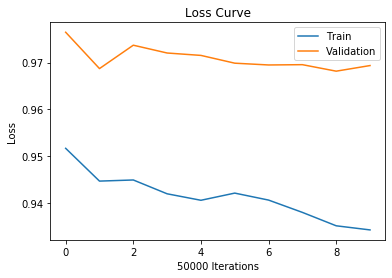

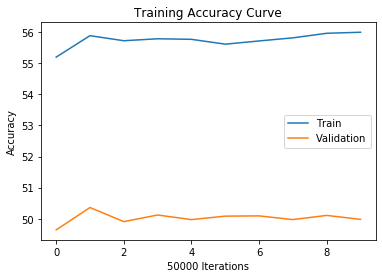

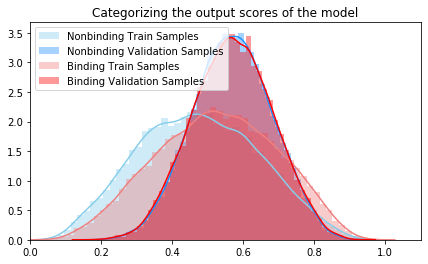

 73%|███████▎  | 49994/68883 [19:40<10:01, 31.39it/s]

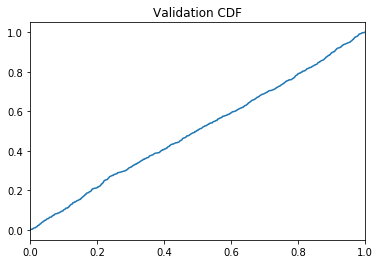

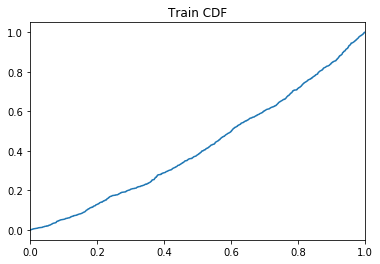

 73%|███████▎  | 50006/68883 [20:21<10:33:32,  2.01s/it]

Training AUC at epoch 4: 0.42094790909090907
Validation AUC epoch 4: 0.5016705454545454
Training Accuracy at epoch 4: 56.0
Validation Accuracy epoch 4: 49.98


 80%|███████▉  | 55010/68883 [22:18<04:44, 48.82it/s]   

Train: Sensitivity: 0.5601249727530335 Specificity: 0.5608939360850258
Val: Sensitivity: 0.7261068038547931 Specificity: 0.2714431710343821


 87%|████████▋ | 60008/68883 [24:13<02:46, 53.44it/s]

Train: Sensitivity: 0.5603545957475171 Specificity: 0.5599453223978129
Val: Sensitivity: 0.727562400424854 Specificity: 0.2717929833958222


 94%|█████████▍| 65011/68883 [26:06<01:05, 58.77it/s]

Train: Sensitivity: 0.5608509590221976 Specificity: 0.5599803191980073
Val: Sensitivity: 0.7273061599754826 Specificity: 0.2720420142106889


  0%|          | 6/68883 [00:00<20:29, 56.04it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 5  with learning rate:  [5e-05]


  2%|▏         | 1124/68883 [00:25<19:36, 57.61it/s]

Train: Sensitivity: 0.5605956668381639 Specificity: 0.5596047295367568
Val: Sensitivity: 0.7264320063739579 Specificity: 0.2723412800872135


  9%|▉         | 6121/68883 [02:21<17:01, 61.43it/s]

Train: Sensitivity: 0.560935292078812 Specificity: 0.5600512095591177
Val: Sensitivity: 0.7260022848641037 Specificity: 0.2722089879821204


 16%|█▌        | 11129/68883 [04:18<34:31, 27.88it/s]

Train: Sensitivity: 0.5621920412195793 Specificity: 0.5608585921687198
Val: Sensitivity: 0.7271188550093342 Specificity: 0.27206528562460763


 23%|██▎       | 16128/68883 [06:15<23:18, 37.72it/s]

Train: Sensitivity: 0.5619729589673529 Specificity: 0.561110327645372
Val: Sensitivity: 0.725873339425037 Specificity: 0.27271438361019873


 31%|███       | 21126/68883 [08:10<18:32, 42.92it/s]

Train: Sensitivity: 0.5630765810825831 Specificity: 0.5610352104853937
Val: Sensitivity: 0.7255679050613293 Specificity: 0.273698532363831


 45%|████▌     | 31113/68883 [12:03<12:50, 49.02it/s]

Train: Sensitivity: 0.5629556926528323 Specificity: 0.5617062065660197
Val: Sensitivity: 0.725908656145385 Specificity: 0.27503211819495743


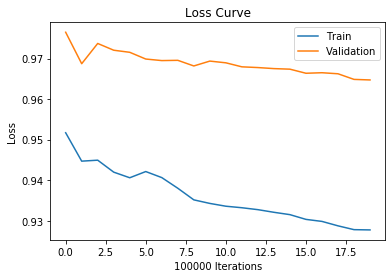

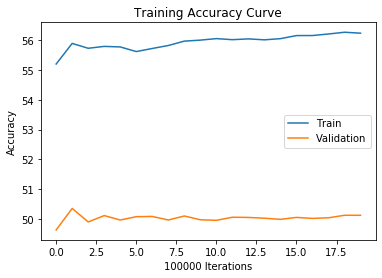

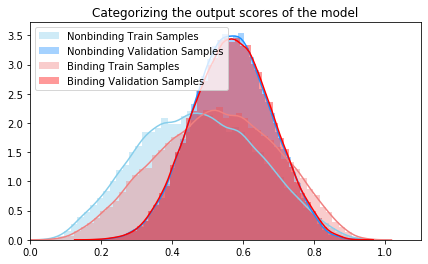

 45%|████▌     | 31113/68883 [12:20<12:50, 49.02it/s]

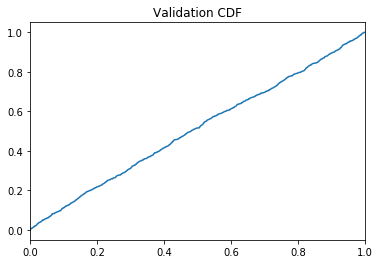

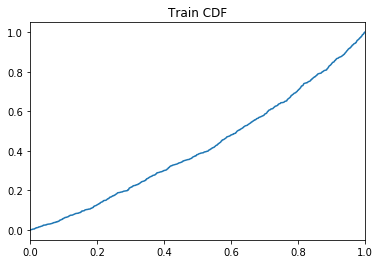

 45%|████▌     | 31124/68883 [13:00<31:41:38,  3.02s/it]

Training AUC at epoch 5: 0.41795590909090913
Validation AUC epoch 5: 0.5092110909090909
Training Accuracy at epoch 5: 56.233
Validation Accuracy epoch 5: 50.13


 52%|█████▏    | 36126/68883 [14:57<09:29, 57.50it/s]   

Train: Sensitivity: 0.5631327092825958 Specificity: 0.5623346718176109
Val: Sensitivity: 0.7255050744569856 Specificity: 0.27571961365592423


 60%|█████▉    | 41130/68883 [16:54<07:33, 61.23it/s]

Train: Sensitivity: 0.5635129972895785 Specificity: 0.5631053846293638
Val: Sensitivity: 0.7250987354614298 Specificity: 0.2762125469873362


 67%|██████▋   | 46121/68883 [18:50<06:24, 59.27it/s]

Train: Sensitivity: 0.5645915546824748 Specificity: 0.5638255302120848
Val: Sensitivity: 0.725406996882577 Specificity: 0.2764757247642333


 74%|███████▍  | 51125/68883 [20:48<09:18, 31.81it/s]

Train: Sensitivity: 0.565348581335645 Specificity: 0.5642683373879428
Val: Sensitivity: 0.7245787332945962 Specificity: 0.27701832176022756


 81%|████████▏ | 56125/68883 [22:43<05:38, 37.72it/s]

Train: Sensitivity: 0.565202086466767 Specificity: 0.5648939233944513
Val: Sensitivity: 0.7243269951068679 Specificity: 0.27689169437350425


 89%|████████▊ | 61130/68883 [24:41<02:41, 47.96it/s]

Train: Sensitivity: 0.5660966863158543 Specificity: 0.5647038922293817
Val: Sensitivity: 0.725033319545935 Specificity: 0.2774902275852479


 96%|█████████▌| 66128/68883 [26:37<00:51, 53.24it/s]

Train: Sensitivity: 0.5660878205033144 Specificity: 0.565009546080187
Val: Sensitivity: 0.7243455420122186 Specificity: 0.27786536573757326


  0%|          | 7/68883 [00:00<18:40, 61.45it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 6  with learning rate:  [5e-05]


  3%|▎         | 2245/68883 [00:51<19:46, 56.16it/s]

Train: Sensitivity: 0.5661281098084072 Specificity: 0.5647302312303739
Val: Sensitivity: 0.7240167340201491 Specificity: 0.2789140037863576


 11%|█         | 7241/68883 [02:47<18:22, 55.90it/s]

Train: Sensitivity: 0.5669528252408425 Specificity: 0.5652689328150415
Val: Sensitivity: 0.7239375077290903 Specificity: 0.27905237943591377


 18%|█▊        | 12231/68883 [04:40<16:19, 57.83it/s]

Train: Sensitivity: 0.5674474474474475 Specificity: 0.5657942057942058
Val: Sensitivity: 0.724050464807437 Specificity: 0.27910307898259706


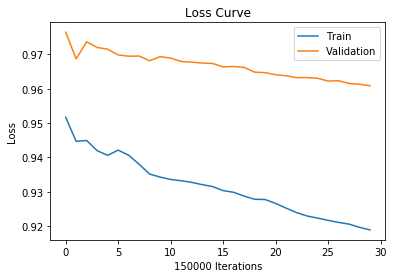

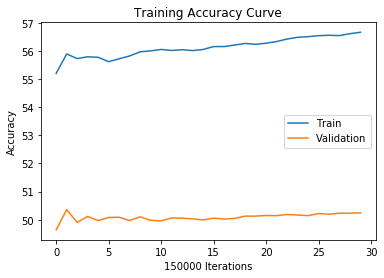

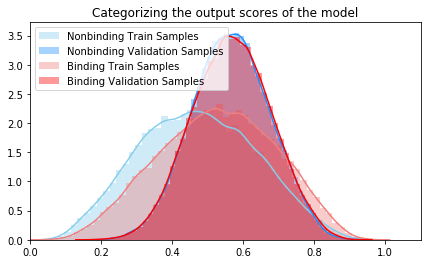

 18%|█▊        | 12231/68883 [05:00<16:19, 57.83it/s]

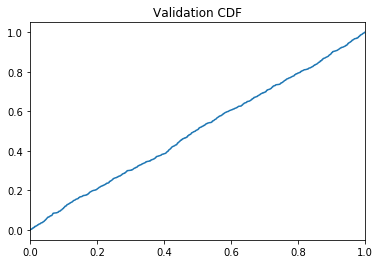

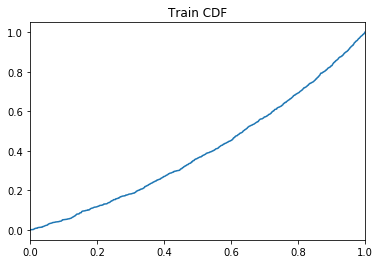

 18%|█▊        | 12241/68883 [05:38<63:34:14,  4.04s/it]

Training AUC at epoch 6: 0.4024583636363636
Validation AUC epoch 6: 0.5008968181818182
Training Accuracy at epoch 6: 56.662
Validation Accuracy epoch 6: 50.24666666666667


 25%|██▌       | 17236/68883 [07:33<14:15, 60.34it/s]   

Train: Sensitivity: 0.5675469748821592 Specificity: 0.565964030168246
Val: Sensitivity: 0.7235095295009702 Specificity: 0.2795864695746803


 32%|███▏      | 22242/68883 [09:28<23:31, 33.04it/s]

Train: Sensitivity: 0.5678958296850374 Specificity: 0.5664051765058585
Val: Sensitivity: 0.7230163869103949 Specificity: 0.28012849470461276


 40%|███▉      | 27245/68883 [11:25<18:27, 37.61it/s]

Train: Sensitivity: 0.5681465119666003 Specificity: 0.5668127451455135
Val: Sensitivity: 0.7231515678180896 Specificity: 0.2806344800720668


 47%|████▋     | 32246/68883 [13:22<12:35, 48.48it/s]

Train: Sensitivity: 0.5683948930556865 Specificity: 0.5670184262480022
Val: Sensitivity: 0.7225568314975392 Specificity: 0.2810181904086936


 54%|█████▍    | 37243/68883 [15:18<11:03, 47.67it/s]

Train: Sensitivity: 0.5687833108401766 Specificity: 0.5674805289724322
Val: Sensitivity: 0.7223682862703589 Specificity: 0.2815731188101768


 61%|██████▏   | 42244/68883 [17:16<08:02, 55.20it/s]

Train: Sensitivity: 0.5691878432157229 Specificity: 0.5682015059638835
Val: Sensitivity: 0.7223310642536942 Specificity: 0.28223746584128045


 69%|██████▊   | 47246/68883 [19:11<06:00, 60.04it/s]

Train: Sensitivity: 0.5698713096139288 Specificity: 0.5683778234086242
Val: Sensitivity: 0.7221372730601081 Specificity: 0.28254498882063084


 76%|███████▌  | 52244/68883 [21:06<04:33, 60.81it/s]

Train: Sensitivity: 0.5702494130528621 Specificity: 0.5689297704621278
Val: Sensitivity: 0.7218640247418358 Specificity: 0.2830418009829308


 83%|████████▎ | 57239/68883 [23:01<03:08, 61.79it/s]

Train: Sensitivity: 0.5704362636460641 Specificity: 0.5692564796587927
Val: Sensitivity: 0.7217584977370018 Specificity: 0.283296094562453


 90%|█████████ | 62231/68883 [24:55<01:49, 60.90it/s]

Train: Sensitivity: 0.5708266613290632 Specificity: 0.5695043964828137
Val: Sensitivity: 0.7220047998884673 Specificity: 0.28374890792420243


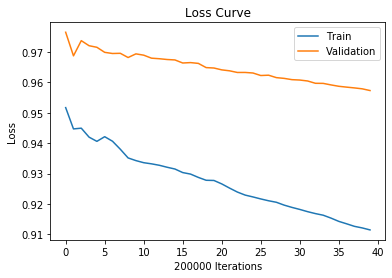

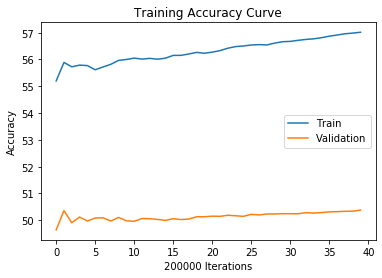

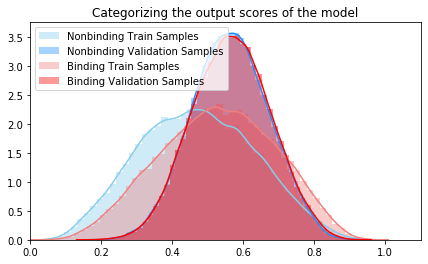

 90%|█████████ | 62231/68883 [25:10<01:49, 60.90it/s]

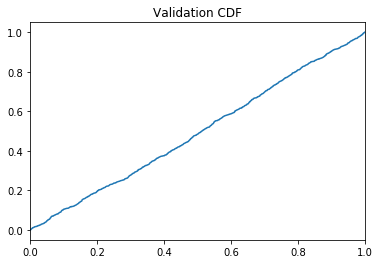

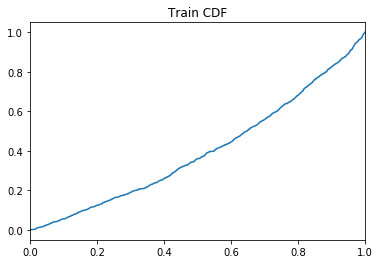

 90%|█████████ | 62241/68883 [25:54<7:32:27,  4.09s/it] 

Training AUC at epoch 6: 0.3992376363636364
Validation AUC epoch 6: 0.4927833636363636
Training Accuracy at epoch 6: 57.0165
Validation Accuracy epoch 6: 50.3795


 98%|█████████▊| 67247/68883 [27:50<00:36, 44.40it/s]  

Train: Sensitivity: 0.5708356526919208 Specificity: 0.5695753452695392
Val: Sensitivity: 0.721197104406549 Specificity: 0.28415536072880443


  0%|          | 0/68883 [00:00<?, ?it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 7  with learning rate:  [5e-05]


  5%|▍         | 3360/68883 [01:16<25:07, 43.46it/s]

Train: Sensitivity: 0.5709927739327728 Specificity: 0.5697132309565945
Val: Sensitivity: 0.7209478816855446 Specificity: 0.2847513051460042


 12%|█▏        | 8359/68883 [03:11<20:46, 48.55it/s]

Train: Sensitivity: 0.5719192426907933 Specificity: 0.5700075301904859
Val: Sensitivity: 0.7212221717822104 Specificity: 0.28499640391926095


 19%|█▉        | 13360/68883 [05:06<17:06, 54.12it/s]

Train: Sensitivity: 0.5720382942322043 Specificity: 0.5706268049475998
Val: Sensitivity: 0.7210742679150293 Specificity: 0.2852540114273197


 27%|██▋       | 18358/68883 [07:00<14:58, 56.21it/s]

Train: Sensitivity: 0.5725292029572164 Specificity: 0.5708411414158459
Val: Sensitivity: 0.7208913205141825 Specificity: 0.2854682089179251


 34%|███▍      | 23361/68883 [08:57<12:08, 62.51it/s]

Train: Sensitivity: 0.5727950840361734 Specificity: 0.5712411714114448
Val: Sensitivity: 0.7208093687201164 Specificity: 0.286132062294853


 41%|████      | 28356/68883 [10:50<11:15, 59.98it/s]

Train: Sensitivity: 0.5731097306371484 Specificity: 0.5713690724103052
Val: Sensitivity: 0.7209899563503835 Specificity: 0.2865871896765372


 48%|████▊     | 33362/68883 [12:47<18:16, 32.41it/s]

Train: Sensitivity: 0.5732877283724034 Specificity: 0.5716973278947807
Val: Sensitivity: 0.7202317223978952 Specificity: 0.28702797232053956


 56%|█████▌    | 38359/68883 [14:42<13:05, 38.88it/s]

Train: Sensitivity: 0.5736661491951957 Specificity: 0.5719517168257076
Val: Sensitivity: 0.7198965651834505 Specificity: 0.2876729168032518


 63%|██████▎   | 43350/68883 [16:37<11:08, 38.19it/s]

Train: Sensitivity: 0.5742263501341126 Specificity: 0.5726229966827865
Val: Sensitivity: 0.7199107640825432 Specificity: 0.28816772431520604


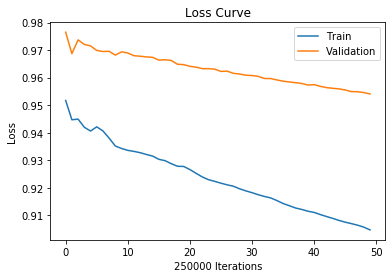

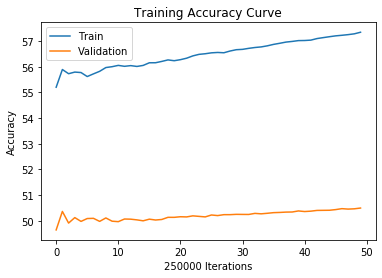

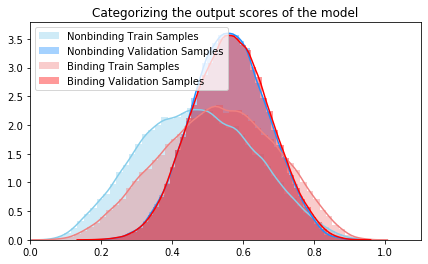

 63%|██████▎   | 43350/68883 [16:50<11:08, 38.19it/s]

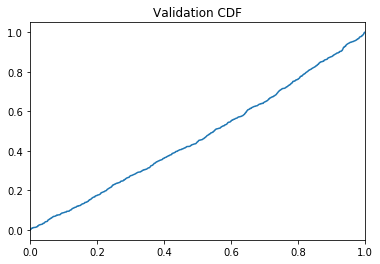

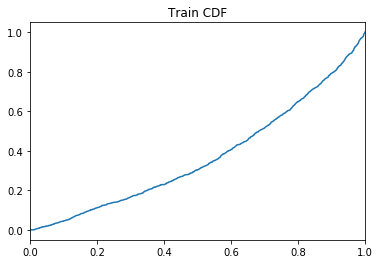

 63%|██████▎   | 43358/68883 [17:35<86:36:15, 12.21s/it] 

Training AUC at epoch 7: 0.37023327272727274
Validation AUC epoch 7: 0.46848554545454546
Training Accuracy at epoch 7: 57.3424
Validation Accuracy epoch 7: 50.492


 70%|███████   | 48361/68883 [19:29<06:52, 49.70it/s]   

Train: Sensitivity: 0.5746495895528245 Specificity: 0.5727476524165609
Val: Sensitivity: 0.7195124809562874 Specificity: 0.28863430573599463


 77%|███████▋  | 53359/68883 [21:24<04:55, 52.48it/s]

Train: Sensitivity: 0.5749109348189072 Specificity: 0.5734587316112858
Val: Sensitivity: 0.7194471684236332 Specificity: 0.28915132229362334


 85%|████████▍ | 58360/68883 [23:19<02:55, 59.86it/s]

Train: Sensitivity: 0.5751485903739115 Specificity: 0.573569451462791
Val: Sensitivity: 0.7193122269921585 Specificity: 0.2894742823374321


 92%|█████████▏| 63364/68883 [25:13<01:30, 60.79it/s]

Train: Sensitivity: 0.5754967378410439 Specificity: 0.5737492599171107
Val: Sensitivity: 0.7193528634978716 Specificity: 0.28987943383736586


 99%|█████████▉| 68357/68883 [27:11<00:08, 58.81it/s]

Train: Sensitivity: 0.575600273745213 Specificity: 0.5740377490083257
Val: Sensitivity: 0.7189632441360126 Specificity: 0.2904989996641208


  0%|          | 7/68883 [00:00<17:52, 64.22it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 8  with learning rate:  [5e-05]


  6%|▋         | 4476/68883 [01:44<33:29, 32.05it/s]

Train: Sensitivity: 0.5758537614114855 Specificity: 0.5742832877768183
Val: Sensitivity: 0.7186074805586584 Specificity: 0.29091639237283884


 14%|█▍        | 9481/68883 [03:40<23:01, 42.99it/s]

Train: Sensitivity: 0.5764300114499259 Specificity: 0.5746524491555723
Val: Sensitivity: 0.7189531064365084 Specificity: 0.2911704601507998


 21%|██        | 14480/68883 [05:38<19:06, 47.46it/s]

Train: Sensitivity: 0.5765638912471787 Specificity: 0.5749340205759332
Val: Sensitivity: 0.7184690099533586 Specificity: 0.29159886720075334


 28%|██▊       | 19476/68883 [07:34<17:09, 47.97it/s]

Train: Sensitivity: 0.5770734090631489 Specificity: 0.5751520652424238
Val: Sensitivity: 0.7184222787955729 Specificity: 0.29200274992682745


 29%|██▉       | 20015/68883 [07:47<13:34, 60.02it/s]

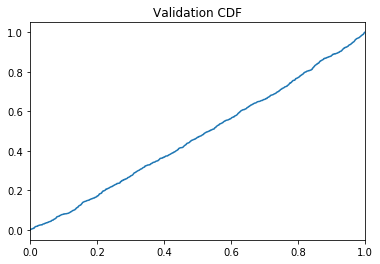

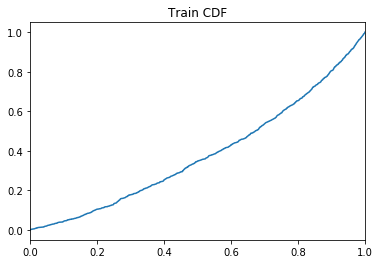

 36%|███▌      | 24475/68883 [10:29<152:34:33, 12.37s/it]

Training AUC at epoch 8: 0.3820629090909091
Validation AUC epoch 8: 0.47407200000000005
Training Accuracy at epoch 8: 57.63733333333333
Validation Accuracy epoch 8: 50.60933333333333


 43%|████▎     | 29480/68883 [12:23<11:08, 58.93it/s]    

Train: Sensitivity: 0.5775190744461516 Specificity: 0.5757357467485691
Val: Sensitivity: 0.7180168765348242 Specificity: 0.29276835563046455


 50%|█████     | 34478/68883 [14:19<09:31, 60.24it/s]

Train: Sensitivity: 0.5777342942756768 Specificity: 0.5760866762916366
Val: Sensitivity: 0.7176758622019163 Specificity: 0.2934946657943659


 57%|█████▋    | 39470/68883 [16:12<07:50, 62.53it/s]

Train: Sensitivity: 0.5781154667480171 Specificity: 0.5764702897447608
Val: Sensitivity: 0.717212985156749 Specificity: 0.2938405543054927


 65%|██████▍   | 44480/68883 [18:07<12:36, 32.28it/s]

Train: Sensitivity: 0.5785414972793795 Specificity: 0.5770220473424521
Val: Sensitivity: 0.7172875237294992 Specificity: 0.29431072896727023


 66%|██████▌   | 45341/68883 [18:27<07:22, 53.18it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 7/68883 [00:00<17:19, 66.25it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 9  with learning rate:  [4.05e-05]


  1%|          | 592/68883 [00:13<20:13, 56.29it/s]

Train: Sensitivity: 0.5801020023324766 Specificity: 0.5783343276320438
Val: Sensitivity: 0.7162059169957736 Specificity: 0.2963551488905963


  8%|▊         | 5579/68883 [02:08<18:42, 56.41it/s]

Train: Sensitivity: 0.5804213801228454 Specificity: 0.5786486702522466
Val: Sensitivity: 0.715955079203356 Specificity: 0.29677648827109854


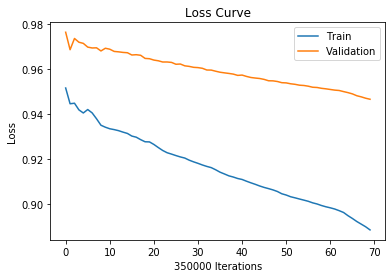

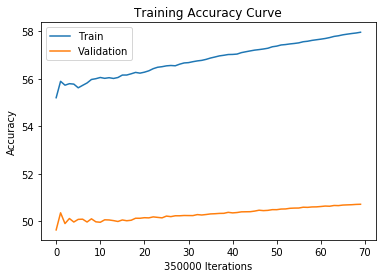

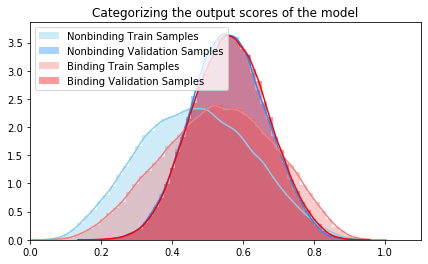

  8%|▊         | 5579/68883 [02:20<18:42, 56.41it/s]

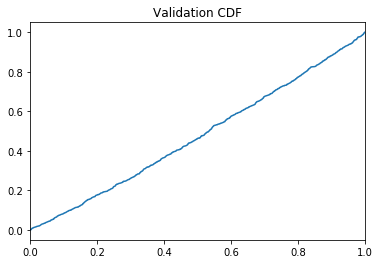

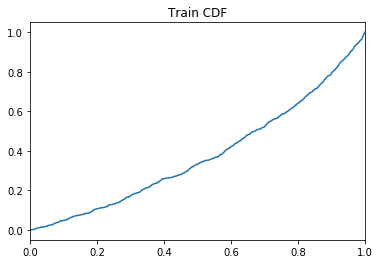

  8%|▊         | 5591/68883 [03:07<36:17:55,  2.06s/it]

Training AUC at epoch 9: 0.37665045454545454
Validation AUC epoch 9: 0.47422
Training Accuracy at epoch 9: 57.953428571428574
Validation Accuracy epoch 9: 50.71885714285714


 15%|█▌        | 10590/68883 [05:01<16:10, 60.07it/s]  

Train: Sensitivity: 0.5808890693189891 Specificity: 0.5789435168818887
Val: Sensitivity: 0.7159497051546044 Specificity: 0.2972320120381737


 23%|██▎       | 15594/68883 [06:57<28:58, 30.66it/s]

Train: Sensitivity: 0.5809422127318831 Specificity: 0.5792427068069802
Val: Sensitivity: 0.7154579508545944 Specificity: 0.2976220359121107


 30%|██▉       | 20598/68883 [08:51<18:07, 44.40it/s]

Train: Sensitivity: 0.581474677123036 Specificity: 0.579436642851277
Val: Sensitivity: 0.7152891862832317 Specificity: 0.2980652330577239


 37%|███▋      | 25595/68883 [10:46<16:32, 43.62it/s]

Train: Sensitivity: 0.5817909252283846 Specificity: 0.579860061331145
Val: Sensitivity: 0.7152693659791872 Specificity: 0.29842767124923336


 44%|████▍     | 30595/68883 [12:41<12:53, 49.47it/s]

Train: Sensitivity: 0.5819406921738016 Specificity: 0.579933513046999
Val: Sensitivity: 0.7151356433697563 Specificity: 0.2988235546107342


 52%|█████▏    | 35597/68883 [14:34<10:00, 55.45it/s]

Train: Sensitivity: 0.5822076581038079 Specificity: 0.5804572317917008
Val: Sensitivity: 0.7147799648782533 Specificity: 0.2992733902290802


 59%|█████▉    | 40596/68883 [16:30<08:06, 58.10it/s]

Train: Sensitivity: 0.5824923177712957 Specificity: 0.580755995910169
Val: Sensitivity: 0.714443904003974 Specificity: 0.29984562589312724


 66%|██████▌   | 45595/68883 [18:24<06:15, 62.07it/s]

Train: Sensitivity: 0.5830006670429473 Specificity: 0.5811644713238686
Val: Sensitivity: 0.7143725389050904 Specificity: 0.30027342523030026


 73%|███████▎  | 50586/68883 [20:18<05:01, 60.62it/s]

Train: Sensitivity: 0.5832205889059483 Specificity: 0.5814440604904605
Val: Sensitivity: 0.713942077368015 Specificity: 0.30070004727988164


 81%|████████  | 55583/68883 [22:12<03:38, 60.81it/s]

Train: Sensitivity: 0.5835343093596453 Specificity: 0.5816870022284178
Val: Sensitivity: 0.7138289448127139 Specificity: 0.30117312798992024


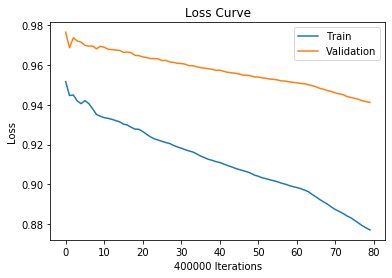

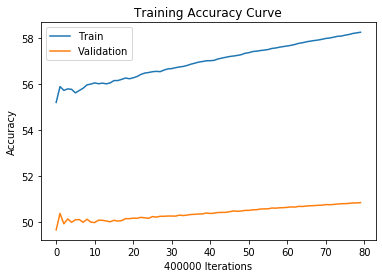

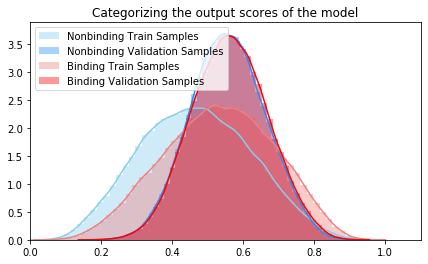

 81%|████████  | 55583/68883 [22:30<03:38, 60.81it/s]

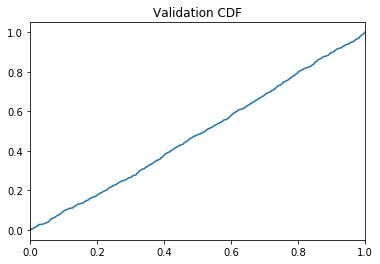

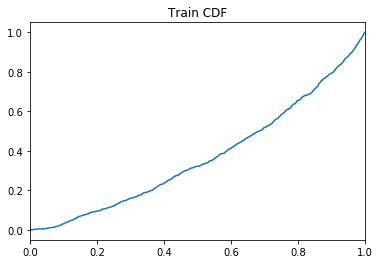

 81%|████████  | 55591/68883 [23:12<23:08:31,  6.27s/it]

Training AUC at epoch 9: 0.36987090909090914
Validation AUC epoch 9: 0.48387254545454544
Training Accuracy at epoch 9: 58.261
Validation Accuracy epoch 9: 50.8315


 88%|████████▊ | 60595/68883 [25:07<03:40, 37.58it/s]   

Train: Sensitivity: 0.5839495067317767 Specificity: 0.5819139908030552
Val: Sensitivity: 0.7137910682667716 Specificity: 0.3015271717572392


 95%|█████████▌| 65593/68883 [27:04<01:17, 42.66it/s]

Train: Sensitivity: 0.5842052584039255 Specificity: 0.5822452908351
Val: Sensitivity: 0.7134034644444984 Specificity: 0.3019074903890889


  0%|          | 7/68883 [00:00<17:09, 66.87it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 10  with learning rate:  [4.5e-05]


  2%|▏         | 1715/68883 [00:38<21:00, 53.28it/s]

Train: Sensitivity: 0.584408630678173 Specificity: 0.5823547254842484
Val: Sensitivity: 0.7131268719760387 Specificity: 0.30236035303681336


 10%|▉         | 6709/68883 [02:36<20:06, 51.52it/s]

Train: Sensitivity: 0.5848182585032716 Specificity: 0.5827976533170924
Val: Sensitivity: 0.7129094686512792 Specificity: 0.30273260094273774


 17%|█▋        | 11711/68883 [04:32<16:05, 59.23it/s]

Train: Sensitivity: 0.5850594259495668 Specificity: 0.5830884876292197
Val: Sensitivity: 0.7128702662167229 Specificity: 0.30317992817992817


 24%|██▍       | 16714/68883 [06:27<14:40, 59.28it/s]

Train: Sensitivity: 0.585210290598609 Specificity: 0.5833960650923319
Val: Sensitivity: 0.7125570406059624 Specificity: 0.30360736883887085


 32%|███▏      | 21709/68883 [08:24<12:55, 60.85it/s]

Train: Sensitivity: 0.5855382434957067 Specificity: 0.5836633254012734
Val: Sensitivity: 0.7123309000650296 Specificity: 0.30406484550263574


 39%|███▉      | 26709/68883 [10:19<21:29, 32.71it/s]

Train: Sensitivity: 0.5857895000295786 Specificity: 0.5839625511357703
Val: Sensitivity: 0.7122647701911716 Specificity: 0.304542695311252


 46%|████▌     | 31711/68883 [12:15<16:22, 37.83it/s]

Train: Sensitivity: 0.5860573310596482 Specificity: 0.5840707170018002
Val: Sensitivity: 0.7119221454758696 Specificity: 0.30484772730349396


 53%|█████▎    | 36697/68883 [14:11<16:19, 32.86it/s]

Train: Sensitivity: 0.5862690232260188 Specificity: 0.5845547913271673
Val: Sensitivity: 0.7116504940326522 Specificity: 0.30538053760753936


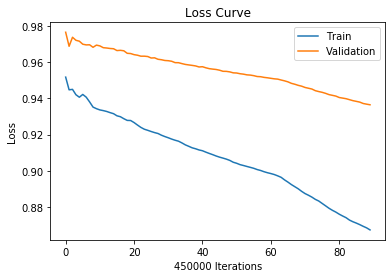

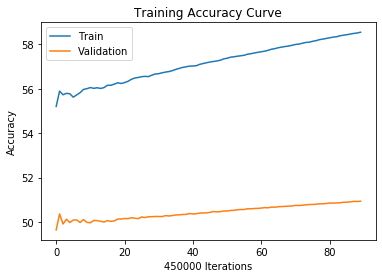

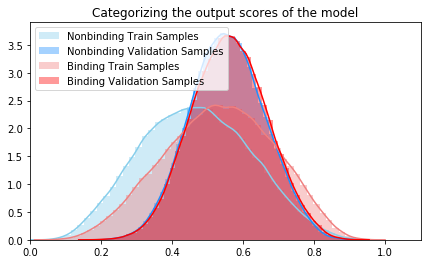

 53%|█████▎    | 36697/68883 [14:30<16:19, 32.86it/s]

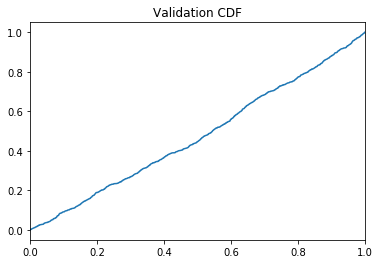

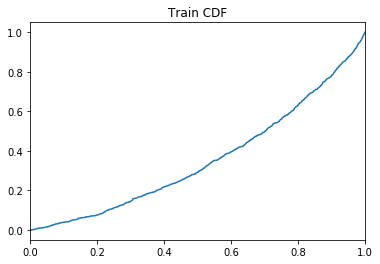

 53%|█████▎    | 36707/68883 [15:11<22:57:42,  2.57s/it]

Training AUC at epoch 10: 0.3559579090909091
Validation AUC epoch 10: 0.47526563636363633
Training Accuracy at epoch 10: 58.541111111111114
Validation Accuracy epoch 10: 50.93244444444444


 61%|██████    | 41711/68883 [17:08<09:38, 46.94it/s]   

Train: Sensitivity: 0.586531228141181 Specificity: 0.5849953225671859
Val: Sensitivity: 0.7113409283956671 Specificity: 0.3058701005269057


 68%|██████▊   | 46714/68883 [19:04<06:47, 54.45it/s]

Train: Sensitivity: 0.5870244352396533 Specificity: 0.5851508463383268
Val: Sensitivity: 0.7113156071366707 Specificity: 0.30619870787497816


 75%|███████▌  | 51711/68883 [20:58<04:57, 57.77it/s]

Train: Sensitivity: 0.5872698864981427 Specificity: 0.5854712058761589
Val: Sensitivity: 0.7110170544362525 Specificity: 0.3067007526849217


 82%|████████▏ | 56712/68883 [22:55<03:25, 59.34it/s]

Train: Sensitivity: 0.587505110036111 Specificity: 0.5856834263165056
Val: Sensitivity: 0.710869979866483 Specificity: 0.3070511588166186


 90%|████████▉ | 61707/68883 [24:50<01:58, 60.58it/s]

Train: Sensitivity: 0.5878109012448692 Specificity: 0.5858749884310871
Val: Sensitivity: 0.7108220533722471 Specificity: 0.30756286888434153


 97%|█████████▋| 66711/68883 [26:46<01:07, 32.26it/s]

Train: Sensitivity: 0.5879433452337259 Specificity: 0.5861292417329914
Val: Sensitivity: 0.7103703580736732 Specificity: 0.3079642241595689


  0%|          | 7/68883 [00:00<17:44, 64.68it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 11  with learning rate:  [4.5e-05]


  4%|▍         | 2830/68883 [01:06<29:10, 37.74it/s]

Train: Sensitivity: 0.5881724069610013 Specificity: 0.5862748006064201
Val: Sensitivity: 0.710203913998809 Specificity: 0.3083825021220214


 11%|█▏        | 7831/68883 [03:00<20:45, 49.02it/s]

Train: Sensitivity: 0.5885954950612342 Specificity: 0.5866183799479613
Val: Sensitivity: 0.7100510643834057 Specificity: 0.30877411529446475


 19%|█▊        | 12825/68883 [04:58<21:12, 44.04it/s]

Train: Sensitivity: 0.5887596820838473 Specificity: 0.5870159223457712
Val: Sensitivity: 0.7099600375075961 Specificity: 0.3091794886356722


 26%|██▌       | 17814/68883 [06:55<19:09, 44.42it/s]

Train: Sensitivity: 0.5890193754529548 Specificity: 0.5872224286816037
Val: Sensitivity: 0.7098651814313716 Specificity: 0.3095109961605809


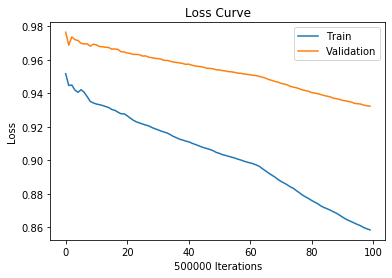

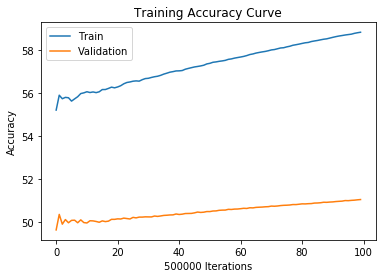

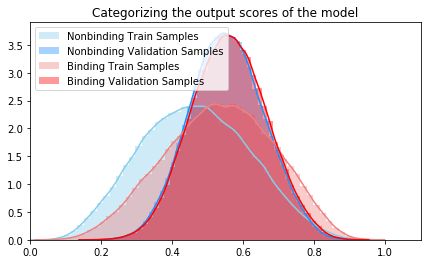

 26%|██▌       | 17814/68883 [07:10<19:09, 44.42it/s]

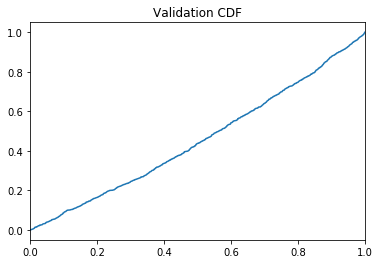

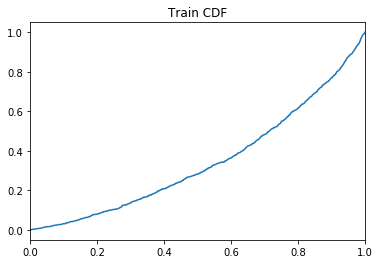

 26%|██▌       | 17825/68883 [07:55<35:46:41,  2.52s/it]

Training AUC at epoch 11: 0.34561363636363635
Validation AUC epoch 11: 0.4552397272727272
Training Accuracy at epoch 11: 58.812
Validation Accuracy epoch 11: 51.0492


 33%|███▎      | 22829/68883 [09:52<13:24, 57.27it/s]   

Train: Sensitivity: 0.5892988096134713 Specificity: 0.5875463441077201
Val: Sensitivity: 0.7096426796266637 Specificity: 0.3099100603573729


 40%|████      | 27830/68883 [11:48<11:10, 61.23it/s]

Train: Sensitivity: 0.589500586921274 Specificity: 0.5877405682365707
Val: Sensitivity: 0.7095989282882685 Specificity: 0.31034686428231106


 48%|████▊     | 32823/68883 [13:42<10:06, 59.48it/s]

Train: Sensitivity: 0.5896830827126129 Specificity: 0.5878877457598187
Val: Sensitivity: 0.709087252164092 Specificity: 0.31072049660378537


 55%|█████▍    | 37826/68883 [15:40<16:13, 31.90it/s]

Train: Sensitivity: 0.59003191296883 Specificity: 0.5882273825946948
Val: Sensitivity: 0.7088763743631 Specificity: 0.31115573232420746


 62%|██████▏   | 42826/68883 [17:35<11:11, 38.78it/s]

Train: Sensitivity: 0.5902835767968062 Specificity: 0.588609401582535
Val: Sensitivity: 0.7086632696036211 Specificity: 0.3116367489165733


 69%|██████▉   | 47829/68883 [19:30<08:08, 43.09it/s]

Train: Sensitivity: 0.590571609843049 Specificity: 0.5888636672146724
Val: Sensitivity: 0.7084432717678101 Specificity: 0.31190564593736503


 77%|███████▋  | 52826/68883 [21:27<05:34, 48.04it/s]

Train: Sensitivity: 0.5908286602496717 Specificity: 0.5891314174284338
Val: Sensitivity: 0.7082874121291552 Specificity: 0.3122654115244873


 84%|████████▍ | 57827/68883 [23:21<03:27, 53.35it/s]

Train: Sensitivity: 0.5910806022372626 Specificity: 0.5892837316713915
Val: Sensitivity: 0.7081902260326782 Specificity: 0.3126652363228016


 91%|█████████ | 62826/68883 [25:18<01:50, 54.81it/s]

Train: Sensitivity: 0.5913688989450795 Specificity: 0.5894328914178448
Val: Sensitivity: 0.7080985066116972 Specificity: 0.3131204079677517


 98%|█████████▊| 67812/68883 [27:13<00:20, 53.41it/s]

Train: Sensitivity: 0.5915287368455537 Specificity: 0.5896877031999797
Val: Sensitivity: 0.7078193473615588 Specificity: 0.3134616086750155


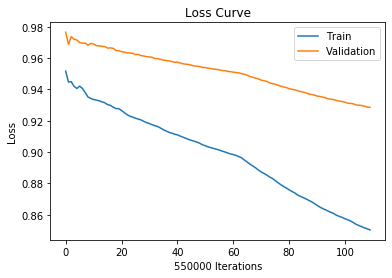

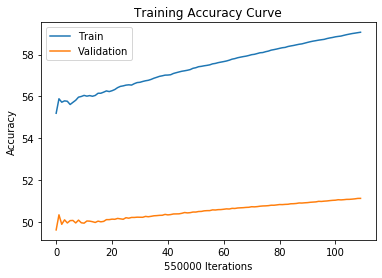

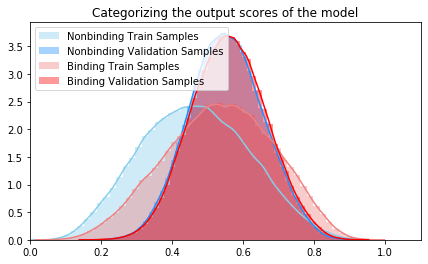

 98%|█████████▊| 67812/68883 [27:30<00:20, 53.41it/s]

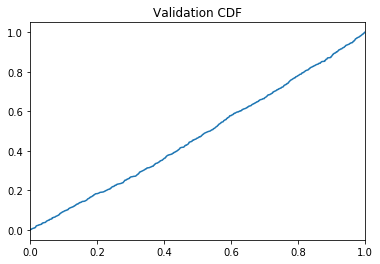

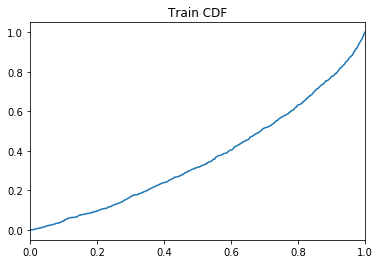

 98%|█████████▊| 67826/68883 [28:15<33:11,  1.88s/it]

Training AUC at epoch 11: 0.36584000000000005
Validation AUC epoch 11: 0.47639863636363633
Training Accuracy at epoch 11: 59.06072727272727
Validation Accuracy epoch 11: 51.14363636363636


  0%|          | 0/68883 [00:00<?, ?it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 12  with learning rate:  [4.5e-05]


  6%|▌         | 3940/68883 [01:31<18:21, 58.93it/s]

Train: Sensitivity: 0.5917436156398788 Specificity: 0.5898941532258064
Val: Sensitivity: 0.7076012476713843 Specificity: 0.31386644766118793


 13%|█▎        | 8948/68883 [03:27<30:28, 32.78it/s]

Train: Sensitivity: 0.5921315577799625 Specificity: 0.5902131834805102
Val: Sensitivity: 0.7075558274701743 Specificity: 0.3142979065214117


 20%|██        | 13948/68883 [05:22<24:10, 37.88it/s]

Train: Sensitivity: 0.5922603229943947 Specificity: 0.5905342226434579
Val: Sensitivity: 0.7072701180834446 Specificity: 0.3146449551685046


 28%|██▊       | 18946/68883 [07:18<19:14, 43.25it/s]

Train: Sensitivity: 0.5925672282335753 Specificity: 0.5907712586017717
Val: Sensitivity: 0.7071425076709092 Specificity: 0.3150915611546781


 35%|███▍      | 23943/68883 [09:14<15:18, 48.94it/s]

Train: Sensitivity: 0.5927407562147483 Specificity: 0.591079991660296
Val: Sensitivity: 0.706897686681703 Specificity: 0.31539946991098833


 42%|████▏     | 28946/68883 [11:09<12:05, 55.01it/s]

Train: Sensitivity: 0.5929870470614229 Specificity: 0.5912942246225064
Val: Sensitivity: 0.7068286333460406 Specificity: 0.3158027760370323


 49%|████▉     | 33943/68883 [13:06<10:35, 54.94it/s]

Train: Sensitivity: 0.5932275892750201 Specificity: 0.5914613112010519
Val: Sensitivity: 0.7064021493732697 Specificity: 0.31626351975231093


 64%|██████▍   | 43940/68883 [16:56<07:02, 59.04it/s]

Train: Sensitivity: 0.5937639827614629 Specificity: 0.5921936868407001
Val: Sensitivity: 0.7059676209861003 Specificity: 0.3170428772005616


 71%|███████   | 48933/68883 [18:51<05:24, 61.45it/s]

Train: Sensitivity: 0.5940245928436559 Specificity: 0.5923467382543183
Val: Sensitivity: 0.7056351074531625 Specificity: 0.3173705400620484


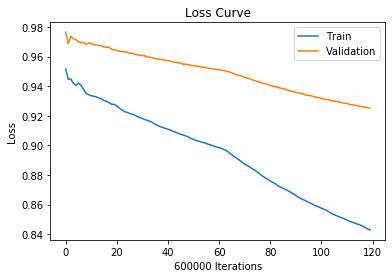

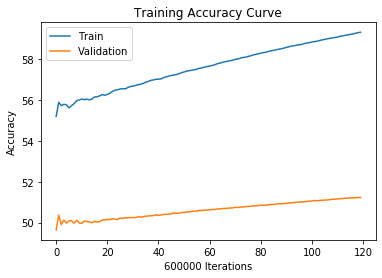

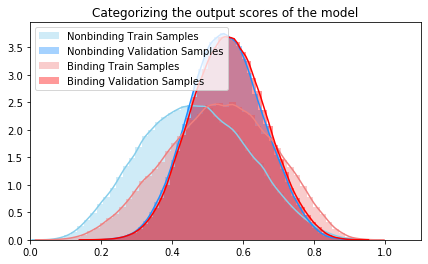

 71%|███████   | 48933/68883 [19:10<05:24, 61.45it/s]

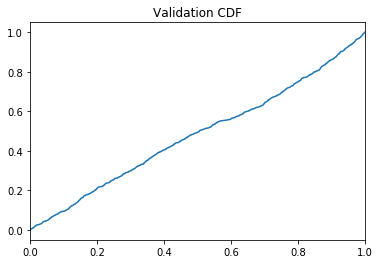

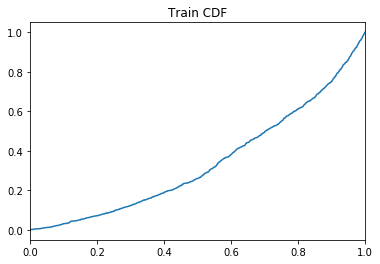

 71%|███████   | 48942/68883 [19:52<23:41:18,  4.28s/it]

Training AUC at epoch 12: 0.34006372727272727
Validation AUC epoch 12: 0.4819372727272727
Training Accuracy at epoch 12: 59.3185
Validation Accuracy epoch 12: 51.228


 78%|███████▊  | 53947/68883 [21:48<06:35, 37.76it/s]   

Train: Sensitivity: 0.5942497403087184 Specificity: 0.5926010346262859
Val: Sensitivity: 0.7055856283008679 Specificity: 0.3178610782894999


 92%|█████████▏| 63412/68883 [25:24<02:02, 44.74it/s]

Train: Sensitivity: 0.606893014760463 Specificity: 0.6052905705446823
Val: Sensitivity: 0.6941975626405846 Specificity: 0.339811148339933


 99%|█████████▉| 68416/68883 [27:19<00:09, 51.61it/s]

Train: Sensitivity: 0.6069913050480829 Specificity: 0.6054638929009128
Val: Sensitivity: 0.6940040553143091 Specificity: 0.34015835302089015


  0%|          | 7/68883 [00:00<17:55, 64.06it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 17  with learning rate:  [4.05e-05]


  7%|▋         | 4520/68883 [01:45<21:50, 49.13it/s]

Train: Sensitivity: 0.6071678018355481 Specificity: 0.6056225773365244
Val: Sensitivity: 0.6937905053653008 Specificity: 0.34053832149359226


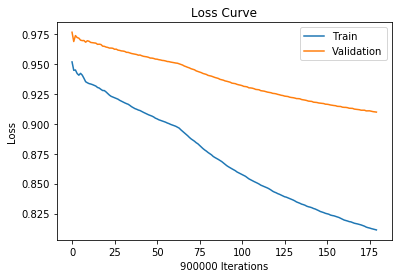

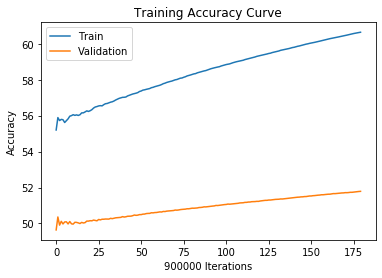

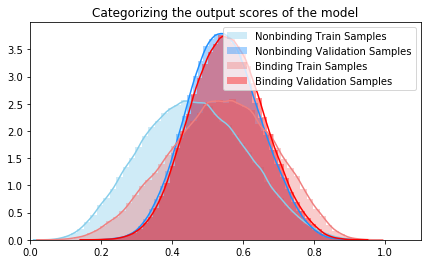

  7%|▋         | 4520/68883 [02:00<21:50, 49.13it/s]

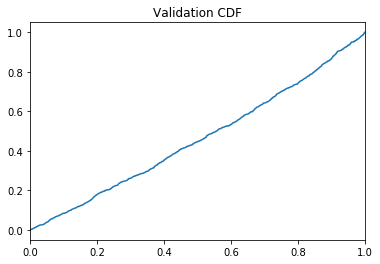

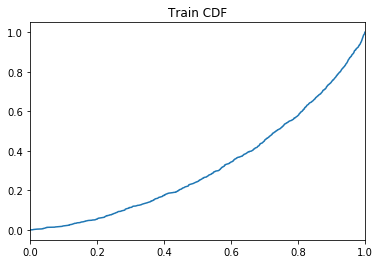

  7%|▋         | 4526/68883 [02:47<234:37:07, 13.12s/it]

Training AUC at epoch 17: 0.32092818181818183
Validation AUC epoch 17: 0.4608880909090909
Training Accuracy at epoch 17: 60.63944444444444
Validation Accuracy epoch 17: 51.78677777777778


 14%|█▍        | 9532/68883 [04:43<17:26, 56.69it/s]    

Train: Sensitivity: 0.6074359689058193 Specificity: 0.6058032382979287
Val: Sensitivity: 0.6936836799602052 Specificity: 0.3409109568219691


 19%|█▉        | 13276/68883 [06:11<24:38, 37.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 86%|████████▋ | 59522/68883 [25:06<02:34, 60.61it/s]

Train: Sensitivity: 0.6094306795790886 Specificity: 0.607867096288237
Val: Sensitivity: 0.6916279894450297 Specificity: 0.34458216377035567


 94%|█████████▎| 64533/68883 [27:01<02:13, 32.49it/s]

Train: Sensitivity: 0.6095678593994699 Specificity: 0.6080669029694645
Val: Sensitivity: 0.6914918782526416 Specificity: 0.3449289246241246


  0%|          | 7/68883 [00:00<17:36, 65.17it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 18  with learning rate:  [4.05e-05]


  1%|          | 650/68883 [00:14<29:54, 38.02it/s]

Train: Sensitivity: 0.6096975555919749 Specificity: 0.6081898952503412
Val: Sensitivity: 0.6913249455551312 Specificity: 0.34522697241788314


  8%|▊         | 5648/68883 [02:08<23:44, 44.39it/s]

Train: Sensitivity: 0.6098554110445654 Specificity: 0.6083418820320772
Val: Sensitivity: 0.6911323463270675 Specificity: 0.345583379737638


 12%|█▏        | 8189/68883 [03:06<33:10, 30.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 81%|████████  | 55649/68883 [22:16<03:57, 55.61it/s]

Train: Sensitivity: 0.611787516975563 Specificity: 0.6102275665890872
Val: Sensitivity: 0.6891556711742327 Specificity: 0.34917278905136506


 88%|████████▊ | 60646/68883 [24:09<02:22, 57.65it/s]

Train: Sensitivity: 0.6120465220745486 Specificity: 0.6104077117264637
Val: Sensitivity: 0.6890674647517806 Specificity: 0.3494685905159325


 28%|██▊       | 19001/68883 [07:19<13:39, 60.87it/s]

Train: Sensitivity: 0.6176254363460487 Specificity: 0.6161860387020947
Val: Sensitivity: 0.6833102884901889 Specificity: 0.3602884845784946


 35%|███▍      | 23994/68883 [09:12<12:40, 59.04it/s]

Train: Sensitivity: 0.6177601908501813 Specificity: 0.6163516649612434
Val: Sensitivity: 0.6831038977925512 Specificity: 0.36060001142622855


 42%|████▏     | 28984/68883 [11:06<10:53, 61.07it/s]

Train: Sensitivity: 0.617921175657954 Specificity: 0.6165119988279207
Val: Sensitivity: 0.6830363071365967 Specificity: 0.3609333583228467


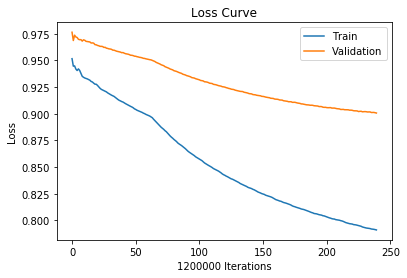

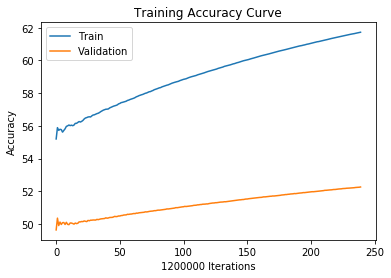

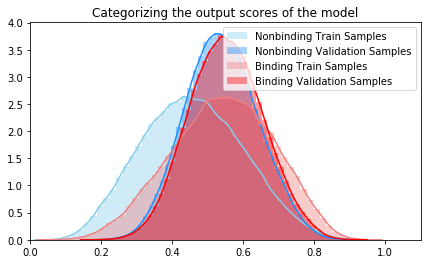

 42%|████▏     | 28984/68883 [11:20<10:53, 61.07it/s]

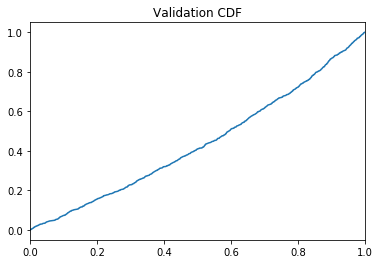

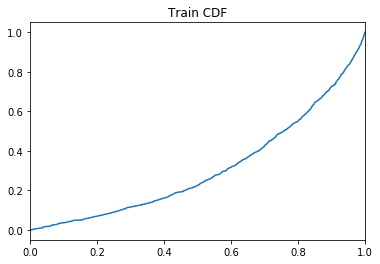

 42%|████▏     | 28995/68883 [12:11<30:28:04,  2.75s/it]

Training AUC at epoch 21: 0.30980081818181815
Validation AUC epoch 21: 0.4386230909090909
Training Accuracy at epoch 21: 61.721583333333335
Validation Accuracy epoch 21: 52.263333333333335


 49%|████▉     | 34001/68883 [14:05<14:55, 38.95it/s]   

Train: Sensitivity: 0.6180632856293176 Specificity: 0.6166451664251343
Val: Sensitivity: 0.6828234469487822 Specificity: 0.3612684012837989


 51%|█████▏    | 35415/68883 [14:37<12:28, 44.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 10104/68883 [03:52<25:11, 38.88it/s]

Train: Sensitivity: 0.6195305230486373 Specificity: 0.6181076497395313
Val: Sensitivity: 0.6814426106203857 Specificity: 0.36409728324693036


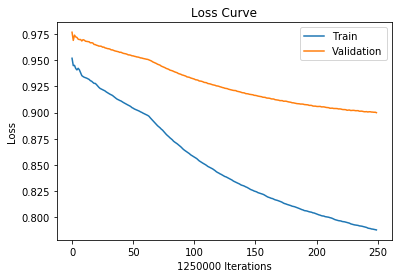

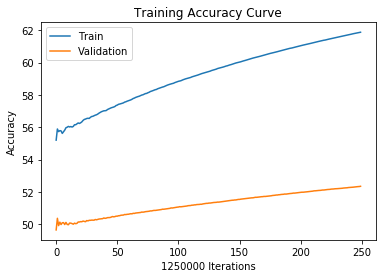

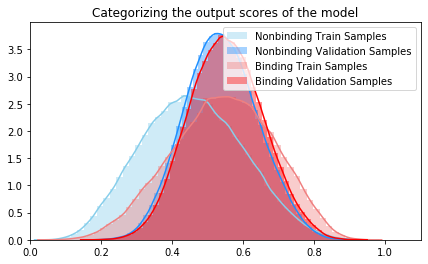

 15%|█▍        | 10104/68883 [04:10<25:11, 38.88it/s]

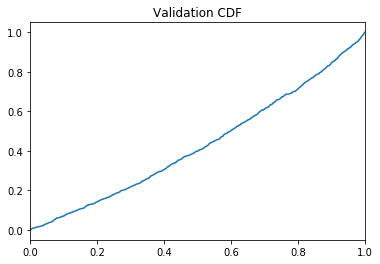

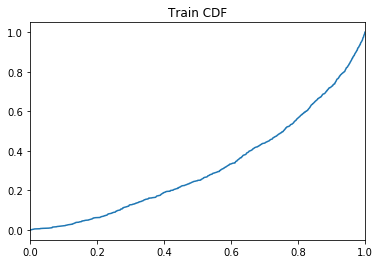

 15%|█▍        | 10112/68883 [04:56<110:43:15,  6.78s/it]

Training AUC at epoch 22: 0.3178679090909091
Validation AUC epoch 22: 0.4306765454545455
Training Accuracy at epoch 22: 61.88184
Validation Accuracy epoch 22: 52.3412


 22%|██▏       | 15114/68883 [06:51<18:27, 48.55it/s]    

Train: Sensitivity: 0.6196260400183757 Specificity: 0.6182525378609367
Val: Sensitivity: 0.6812044849939366 Specificity: 0.3644005964914526


 29%|██▉       | 20115/68883 [08:48<15:05, 53.88it/s]

Train: Sensitivity: 0.6198384136895541 Specificity: 0.6184327997272504
Val: Sensitivity: 0.6810563842317026 Specificity: 0.36475022511215766


 36%|███▋      | 25119/68883 [10:41<12:03, 60.50it/s]

Train: Sensitivity: 0.6199963915143611 Specificity: 0.618620055720865
Val: Sensitivity: 0.6808794095276189 Specificity: 0.36508604200430805


 41%|████      | 28263/68883 [11:53<11:04, 61.09it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▉         | 6224/68883 [02:24<17:12, 60.71it/s]

Train: Sensitivity: 0.6214834187867643 Specificity: 0.6200874623164446
Val: Sensitivity: 0.6792966743975726 Specificity: 0.36807257523909


 39%|███▉      | 26818/68883 [10:17<22:49, 30.71it/s]

Train: Sensitivity: 0.6314316766929479 Specificity: 0.6301137390708693
Val: Sensitivity: 0.6688230614086365 Specificity: 0.388953368148149


 46%|████▌     | 31815/68883 [12:11<16:18, 37.89it/s]

Train: Sensitivity: 0.6315461791083081 Specificity: 0.6302071229030407
Val: Sensitivity: 0.668631106560914 Specificity: 0.38917351008846096


 53%|█████▎    | 36820/68883 [14:07<11:03, 48.29it/s]

Train: Sensitivity: 0.6316601237197423 Specificity: 0.6303636410926967
Val: Sensitivity: 0.6684803043893883 Specificity: 0.38947235843552797


 61%|██████    | 41817/68883 [16:00<09:09, 49.30it/s]

Train: Sensitivity: 0.631774321180125 Specificity: 0.6305206822977449
Val: Sensitivity: 0.6683417971297917 Specificity: 0.38975336474273237


 63%|██████▎   | 43154/68883 [16:30<09:35, 44.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 26%|██▌       | 17933/68883 [06:49<16:32, 51.34it/s]

Train: Sensitivity: 0.6328652380267511 Specificity: 0.6315705468637864
Val: Sensitivity: 0.6673070142097622 Specificity: 0.3920077644267388


 33%|███▎      | 22938/68883 [08:43<13:08, 58.30it/s]

Train: Sensitivity: 0.632974854470737 Specificity: 0.6316808533538519
Val: Sensitivity: 0.6671461318574938 Specificity: 0.39228145597820085


 41%|████      | 27920/68883 [10:38<12:08, 56.21it/s]

Train: Sensitivity: 0.6331036486797232 Specificity: 0.6318062616522606
Val: Sensitivity: 0.6670457106562583 Specificity: 0.39256019112446267


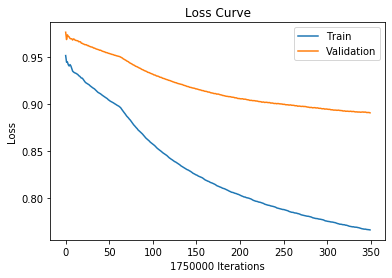

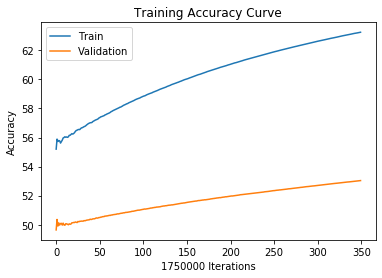

 41%|████      | 27920/68883 [10:50<12:08, 56.21it/s]

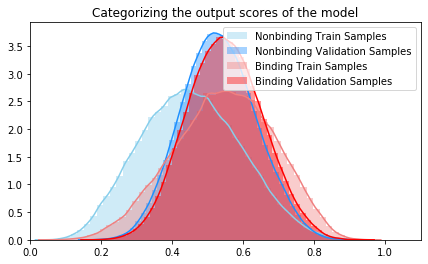

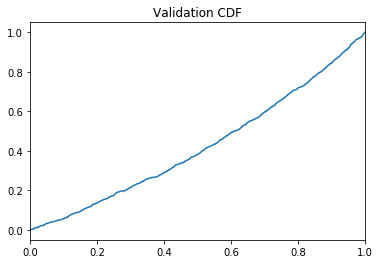

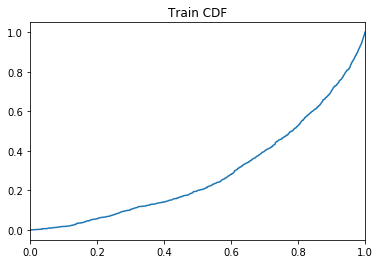

 41%|████      | 27931/68883 [11:47<32:37:56,  2.87s/it]

Training AUC at epoch 29: 0.28891672727272727
Validation AUC epoch 29: 0.4227743636363636
Training Accuracy at epoch 29: 63.24542857142857
Validation Accuracy epoch 29: 53.0356


 48%|████▊     | 32926/68883 [13:40<09:59, 59.96it/s]   

Train: Sensitivity: 0.6332125260807914 Specificity: 0.6319113111725109
Val: Sensitivity: 0.6668373016368472 Specificity: 0.39276891725983637


 52%|█████▏    | 36121/68883 [14:54<09:19, 58.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|██████▉   | 47933/68883 [19:25<07:55, 44.04it/s]

Train: Sensitivity: 0.6336010043317462 Specificity: 0.6323391621417201
Val: Sensitivity: 0.6664610855135065 Specificity: 0.39354277325624926


 77%|███████▋  | 52932/68883 [21:21<05:34, 47.73it/s]

Train: Sensitivity: 0.6337296377998223 Specificity: 0.6324765734407435
Val: Sensitivity: 0.6663352269539045 Specificity: 0.3937708300808428


 84%|████████▍ | 57933/68883 [23:19<03:42, 49.27it/s]

Train: Sensitivity: 0.6338607915246803 Specificity: 0.6325640133358778
Val: Sensitivity: 0.666243262843125 Specificity: 0.39402085627132105


 91%|█████████▏| 62932/68883 [25:14<01:44, 56.85it/s]

Train: Sensitivity: 0.633969357347698 Specificity: 0.6326895889371333
Val: Sensitivity: 0.6661670883137724 Specificity: 0.3942734424481191


 99%|█████████▊| 67937/68883 [27:09<00:15, 59.72it/s]

Train: Sensitivity: 0.6340260954566705 Specificity: 0.6328030646345901
Val: Sensitivity: 0.6660264078923208 Specificity: 0.3944952070046724


  0%|          | 7/68883 [00:00<17:39, 64.98it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 30  with learning rate:  [2.952450000000001e-05]


  6%|▌         | 4047/68883 [01:34<18:22, 58.83it/s]

Train: Sensitivity: 0.6341153849585552 Specificity: 0.6328630073554293
Val: Sensitivity: 0.6658868651535262 Specificity: 0.3947540932257617


 13%|█▎        | 9038/68883 [03:28<16:13, 61.46it/s]

Train: Sensitivity: 0.6342853965076187 Specificity: 0.632972582972583
Val: Sensitivity: 0.6658318734596627 Specificity: 0.39499856646098824


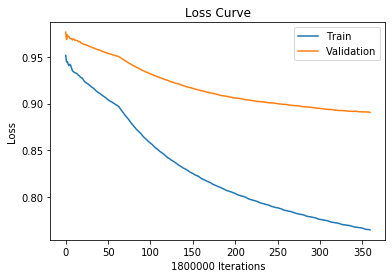

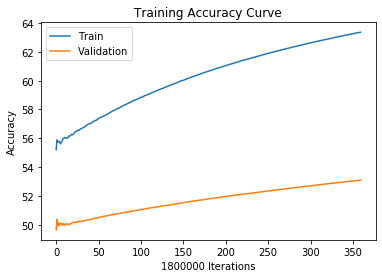

 13%|█▎        | 9038/68883 [03:40<16:13, 61.46it/s]

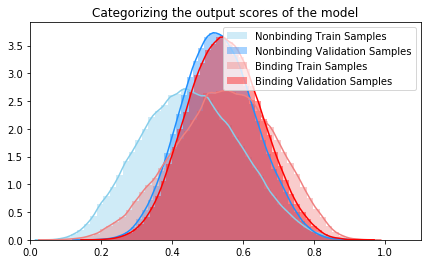

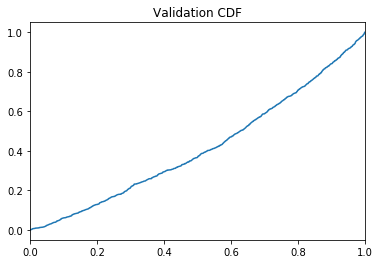

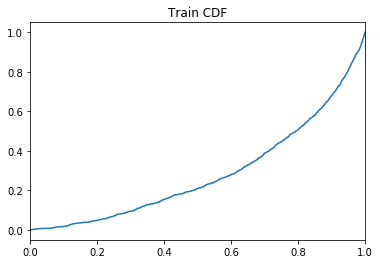

 13%|█▎        | 9048/68883 [04:37<60:18:43,  3.63s/it]

Training AUC at epoch 30: 0.284056
Validation AUC epoch 30: 0.4151456363636364
Training Accuracy at epoch 30: 63.362833333333334
Validation Accuracy epoch 30: 53.09594444444444


 20%|██        | 14051/68883 [06:34<24:44, 36.94it/s]  

Train: Sensitivity: 0.6343561276154456 Specificity: 0.6331054865865605
Val: Sensitivity: 0.66569436994952 Specificity: 0.39524172931745316


 28%|██▊       | 19053/68883 [08:31<18:55, 43.89it/s]

Train: Sensitivity: 0.6344907832419363 Specificity: 0.6332319960789768
Val: Sensitivity: 0.665583347182067 Specificity: 0.3954966478916054


 35%|███▍      | 24055/68883 [10:26<14:01, 53.24it/s]

Train: Sensitivity: 0.6345967815767384 Specificity: 0.6333581753553198
Val: Sensitivity: 0.6654202181486124 Specificity: 0.39574920509183764


 42%|████▏     | 29053/68883 [12:23<12:08, 54.66it/s]

Train: Sensitivity: 0.6347212642635012 Specificity: 0.6334712481159758
Val: Sensitivity: 0.6653193324402182 Specificity: 0.3960218195298915


 49%|████▉     | 34049/68883 [14:22<10:32, 55.12it/s]

Train: Sensitivity: 0.6348289585691844 Specificity: 0.6335755763032511
Val: Sensitivity: 0.6651625445205965 Specificity: 0.39626847525061865


 57%|█████▋    | 39053/68883 [16:17<08:11, 60.63it/s]

Train: Sensitivity: 0.6349484186458664 Specificity: 0.6337030930986669
Val: Sensitivity: 0.6650222228511652 Specificity: 0.39655741860161453


 64%|██████▍   | 44047/68883 [18:14<07:02, 58.81it/s]

Train: Sensitivity: 0.6350646942026139 Specificity: 0.6338759554868355
Val: Sensitivity: 0.6649200223622577 Specificity: 0.39679034367288424


 71%|███████   | 49051/68883 [20:11<10:19, 32.04it/s]

Train: Sensitivity: 0.6352029575697967 Specificity: 0.6339699435423356
Val: Sensitivity: 0.6647645030502823 Specificity: 0.39700757927132047


 78%|███████▊  | 54050/68883 [22:07<06:25, 38.45it/s]

Train: Sensitivity: 0.6353017126799073 Specificity: 0.6340966810888671
Val: Sensitivity: 0.6646811322404796 Specificity: 0.39726556675493385


 86%|████████▌ | 59040/68883 [24:02<04:19, 37.87it/s]

Train: Sensitivity: 0.6354336085149391 Specificity: 0.6342010815621412
Val: Sensitivity: 0.6645866758552369 Specificity: 0.39748618814514114


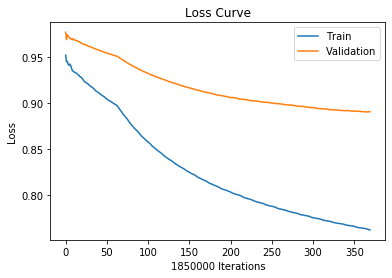

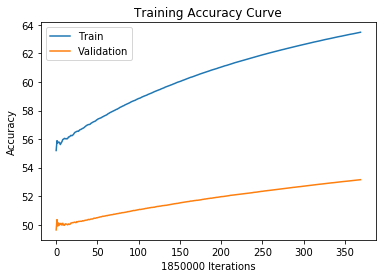

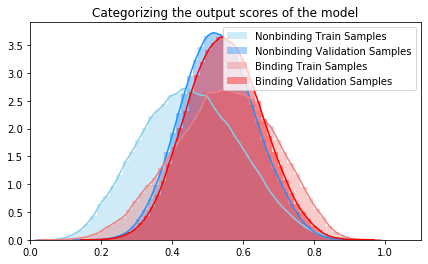

 86%|████████▌ | 59040/68883 [24:20<04:19, 37.87it/s]

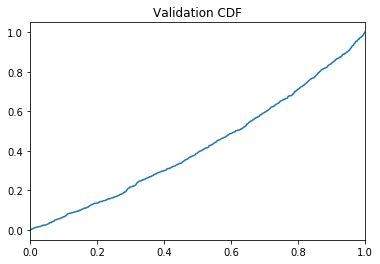

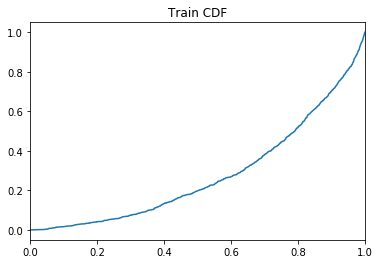

 86%|████████▌ | 59048/68883 [25:12<19:59:05,  7.32s/it]

Training AUC at epoch 30: 0.278743
Validation AUC epoch 30: 0.42274545454545454
Training Accuracy at epoch 30: 63.481675675675675
Validation Accuracy epoch 30: 53.15691891891892


 93%|█████████▎| 64054/68883 [27:08<01:34, 51.01it/s]   

Train: Sensitivity: 0.6355221380669419 Specificity: 0.6343270077961581
Val: Sensitivity: 0.6645071363296146 Specificity: 0.3976957692261894


  0%|          | 7/68883 [00:00<17:27, 65.77it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 31  with learning rate:  [2.952450000000001e-05]


  0%|          | 168/68883 [00:03<21:51, 52.39it/s]

Train: Sensitivity: 0.6355844636702781 Specificity: 0.634416699071677
Val: Sensitivity: 0.6643911832335355 Specificity: 0.3979179059441054


  8%|▊         | 5170/68883 [02:00<19:30, 54.43it/s]

Train: Sensitivity: 0.6357010365052512 Specificity: 0.6344781703178032
Val: Sensitivity: 0.6642722941008713 Specificity: 0.3981752347441851


 15%|█▍        | 10166/68883 [03:58<17:25, 56.15it/s]

Train: Sensitivity: 0.6358188183151516 Specificity: 0.6345973437616865
Val: Sensitivity: 0.6641971179247694 Specificity: 0.39845495000171816


 22%|██▏       | 15161/68883 [05:52<14:52, 60.18it/s]

Train: Sensitivity: 0.635888220867673 Specificity: 0.634709181449761
Val: Sensitivity: 0.6640584412479961 Specificity: 0.39868401183618263


 29%|██▉       | 20166/68883 [07:49<25:14, 32.17it/s]

Train: Sensitivity: 0.6360335225276071 Specificity: 0.6348314964981454
Val: Sensitivity: 0.6639566338234562 Specificity: 0.3989284604202204


 37%|███▋      | 25171/68883 [09:46<19:12, 37.94it/s]

Train: Sensitivity: 0.6361678241761043 Specificity: 0.634962325126369
Val: Sensitivity: 0.663829198132449 Specificity: 0.3991716503290602


 44%|████▍     | 30166/68883 [11:41<14:40, 43.96it/s]

Train: Sensitivity: 0.6362736914361258 Specificity: 0.6350408250421781
Val: Sensitivity: 0.6636986445751386 Specificity: 0.3994315887890185


 51%|█████     | 35167/68883 [13:36<11:47, 47.69it/s]

Train: Sensitivity: 0.6363639244919433 Specificity: 0.6351623487535479
Val: Sensitivity: 0.6635796466921408 Specificity: 0.39963971792032466


 58%|█████▊    | 40154/68883 [15:33<11:00, 43.49it/s]

Train: Sensitivity: 0.6364804990227121 Specificity: 0.6352827976381389
Val: Sensitivity: 0.6634398839155032 Specificity: 0.3999146068745693


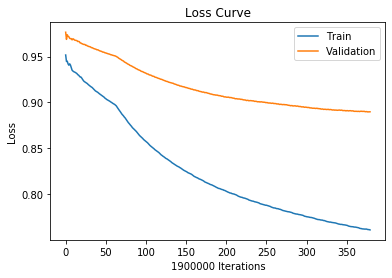

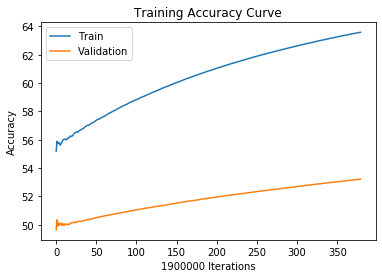

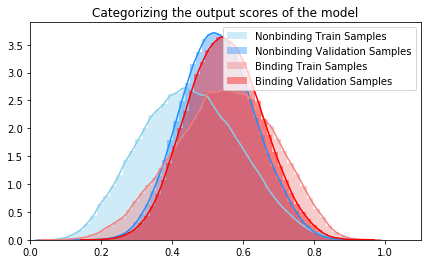

 58%|█████▊    | 40154/68883 [15:50<11:00, 43.49it/s]

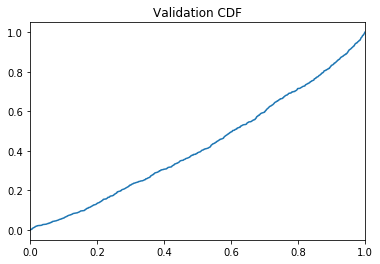

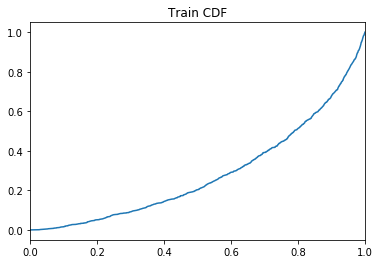

 58%|█████▊    | 40165/68883 [16:46<24:36:04,  3.08s/it]

Training AUC at epoch 31: 0.28365081818181814
Validation AUC epoch 31: 0.42389509090909094
Training Accuracy at epoch 31: 63.58810526315789
Validation Accuracy epoch 31: 53.220263157894735


 66%|██████▌   | 45165/68883 [18:50<07:31, 52.53it/s]   

Train: Sensitivity: 0.6366027508966318 Specificity: 0.63545185932621
Val: Sensitivity: 0.6633456616234654 Specificity: 0.40016106878838953


 73%|███████▎  | 50166/68883 [20:56<05:48, 53.77it/s]

Train: Sensitivity: 0.6367212434320788 Specificity: 0.6355458709885965
Val: Sensitivity: 0.6631874372283808 Specificity: 0.4003503065182034


 80%|████████  | 55161/68883 [23:02<04:08, 55.24it/s]

Train: Sensitivity: 0.6368274975303028 Specificity: 0.6356519425503832
Val: Sensitivity: 0.6630709088979921 Specificity: 0.400604184623386


 87%|████████▋ | 60168/68883 [25:06<04:42, 30.81it/s]

Train: Sensitivity: 0.6369613770063791 Specificity: 0.6357668684842039
Val: Sensitivity: 0.6629769768752004 Specificity: 0.40081347664522987


 95%|█████████▍| 65167/68883 [27:11<01:44, 35.60it/s]

Train: Sensitivity: 0.6370236557529468 Specificity: 0.6358938324244544
Val: Sensitivity: 0.6628781763919416 Specificity: 0.40104125376048866


  0%|          | 7/68883 [00:00<18:51, 60.88it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 32  with learning rate:  [2.952450000000001e-05]


  2%|▏         | 1288/68883 [00:31<25:14, 44.64it/s]

Train: Sensitivity: 0.6371064361236999 Specificity: 0.6359589505536996
Val: Sensitivity: 0.6627776160780452 Specificity: 0.40126684742687224


  9%|▉         | 6284/68883 [02:34<22:47, 45.76it/s]

Train: Sensitivity: 0.6372172613967078 Specificity: 0.6360324526267855
Val: Sensitivity: 0.6626661066294407 Specificity: 0.4015053401906944


 16%|█▋        | 11285/68883 [04:39<19:12, 49.99it/s]

Train: Sensitivity: 0.6373334709251328 Specificity: 0.6361656109995365
Val: Sensitivity: 0.6625930025526288 Specificity: 0.4017639959341767


 24%|██▎       | 16286/68883 [06:35<15:05, 58.12it/s]

Train: Sensitivity: 0.6374077348816958 Specificity: 0.6362756669635401
Val: Sensitivity: 0.6624641798596076 Specificity: 0.40198473250918343


 31%|███       | 21270/68883 [08:28<13:44, 57.73it/s]

Train: Sensitivity: 0.6375336221587993 Specificity: 0.6363823595712851
Val: Sensitivity: 0.662339002304637 Specificity: 0.40223086301776123


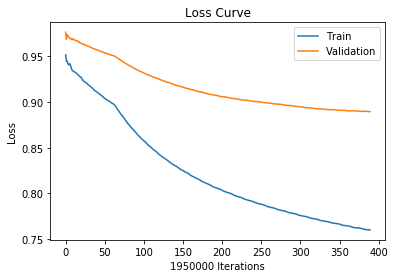

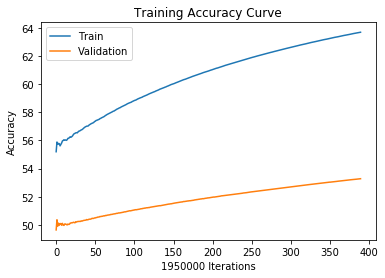

 31%|███       | 21270/68883 [08:40<13:44, 57.73it/s]

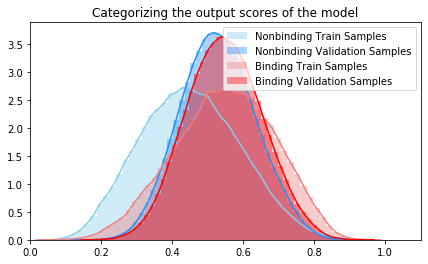

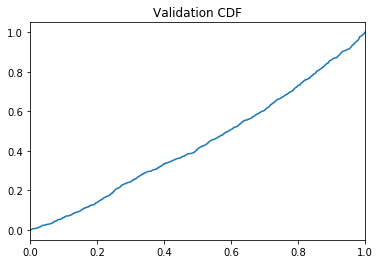

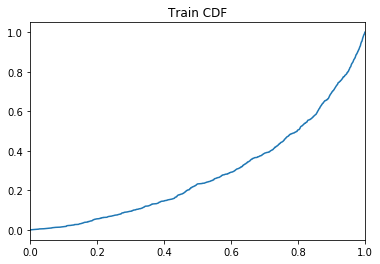

 31%|███       | 21283/68883 [09:37<32:11:51,  2.44s/it]

Training AUC at epoch 32: 0.2873601818181818
Validation AUC epoch 32: 0.4381406363636363
Training Accuracy at epoch 32: 63.69574358974359
Validation Accuracy epoch 32: 53.28046153846154


 38%|███▊      | 26282/68883 [11:32<11:48, 60.13it/s]   

Train: Sensitivity: 0.6376616128255939 Specificity: 0.6365012289029806
Val: Sensitivity: 0.6622363920365101 Specificity: 0.4024513877262162


 45%|████▌     | 31288/68883 [13:27<18:52, 33.19it/s]

Train: Sensitivity: 0.637751240305089 Specificity: 0.6365764974154109
Val: Sensitivity: 0.662100878940393 Specificity: 0.4026604158641434


 53%|█████▎    | 36285/68883 [15:19<14:55, 36.40it/s]

Train: Sensitivity: 0.6378647235797953 Specificity: 0.6366992757270438
Val: Sensitivity: 0.6619868658749967 Specificity: 0.40290957547912143


 60%|█████▉    | 41284/68883 [17:13<10:28, 43.91it/s]

Train: Sensitivity: 0.6379579816390697 Specificity: 0.6368522263716158
Val: Sensitivity: 0.6618621521622843 Specificity: 0.40311130002069173


 67%|██████▋   | 46286/68883 [19:09<07:54, 47.63it/s]

Train: Sensitivity: 0.6380807677415562 Specificity: 0.6369703910693654
Val: Sensitivity: 0.6617698824065753 Specificity: 0.40334081317047826


 74%|███████▍  | 51284/68883 [21:02<05:24, 54.18it/s]

Train: Sensitivity: 0.6382163634488573 Specificity: 0.637091777318955
Val: Sensitivity: 0.6616627815377062 Specificity: 0.4035580742749526


 82%|████████▏ | 56286/68883 [22:56<03:38, 57.59it/s]

Train: Sensitivity: 0.6383128709995582 Specificity: 0.6371813791117974
Val: Sensitivity: 0.6615167848680784 Specificity: 0.40376839713637425


 89%|████████▉ | 61286/68883 [24:53<02:07, 59.58it/s]

Train: Sensitivity: 0.6384376191467808 Specificity: 0.6372911171511105
Val: Sensitivity: 0.6614535004189152 Specificity: 0.40399458723641285


 96%|█████████▌| 66281/68883 [26:49<00:43, 60.27it/s]

Train: Sensitivity: 0.6384949859961124 Specificity: 0.6374078484433009
Val: Sensitivity: 0.6613442902860224 Specificity: 0.4041801500747354


100%|██████████| 68883/68883 [27:48<00:00, 41.27it/s]


Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth


  0%|          | 7/68883 [00:00<17:24, 65.94it/s]

Starting epoch: 33  with learning rate:  [2.952450000000001e-05]


  3%|▎         | 2386/68883 [00:54<18:29, 59.92it/s]

Train: Sensitivity: 0.638578385493566 Specificity: 0.6374687186249681
Val: Sensitivity: 0.6612510607442939 Specificity: 0.40443659963774664


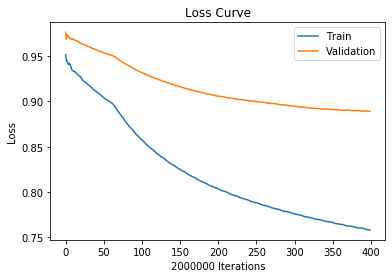

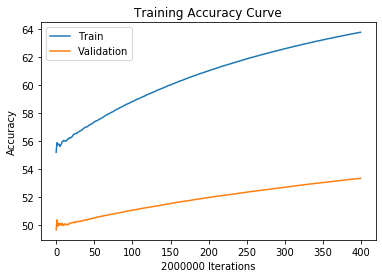

  3%|▎         | 2386/68883 [01:10<18:29, 59.92it/s]

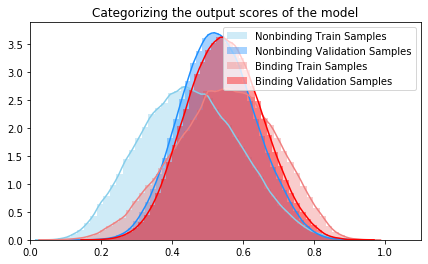

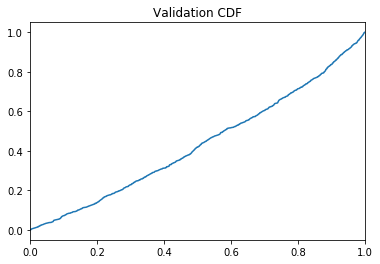

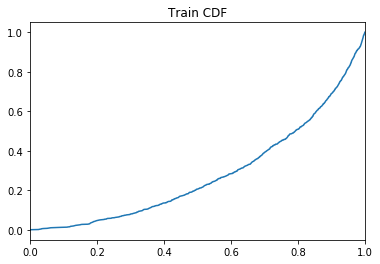

  3%|▎         | 2400/68883 [02:04<38:55:31,  2.11s/it]

Training AUC at epoch 33: 0.2820163636363636
Validation AUC epoch 33: 0.43332218181818183
Training Accuracy at epoch 33: 63.8023
Validation Accuracy epoch 33: 53.3359


 11%|█         | 7403/68883 [04:01<26:47, 38.25it/s]   

Train: Sensitivity: 0.6387084985801752 Specificity: 0.637554959400798
Val: Sensitivity: 0.6611776838771148 Specificity: 0.40465839224676237


 18%|█▊        | 12144/68883 [05:48<21:59, 42.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 76%|███████▌  | 52358/68883 [21:12<05:02, 54.70it/s]

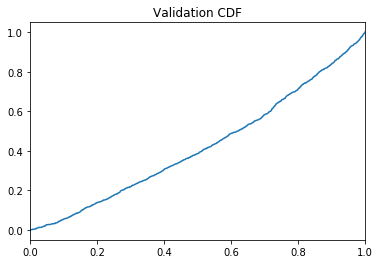

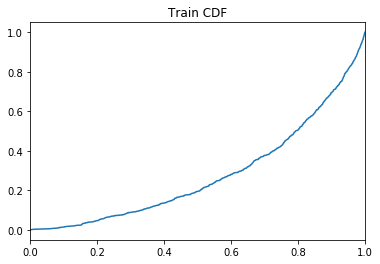

 76%|███████▌  | 52400/68883 [22:24<9:46:56,  2.14s/it] 

Training AUC at epoch 33: 0.2794290909090909
Validation AUC epoch 33: 0.4209840909090909
Training Accuracy at epoch 33: 63.912
Validation Accuracy epoch 33: 53.39156097560976


 91%|█████████ | 62401/68883 [26:13<02:01, 53.40it/s]  

Train: Sensitivity: 0.6398632830152373 Specificity: 0.6388163873782386
Val: Sensitivity: 0.6599706424431366 Specificity: 0.4071027651108247


 98%|█████████▊| 67405/68883 [28:10<00:26, 56.65it/s]

Train: Sensitivity: 0.6399108073390049 Specificity: 0.6388979463486611
Val: Sensitivity: 0.6598443244202681 Specificity: 0.4072593467054729


  0%|          | 0/68883 [00:00<?, ?it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 34  with learning rate:  [2.391484500000001e-05]


  5%|▌         | 3522/68883 [01:20<17:56, 60.74it/s]

Train: Sensitivity: 0.6400035203979983 Specificity: 0.638974311455504
Val: Sensitivity: 0.6597551023550515 Specificity: 0.4075132509176697


 12%|█▏        | 8511/68883 [03:15<17:13, 58.39it/s]

Train: Sensitivity: 0.6401402811411591 Specificity: 0.6390646214287777
Val: Sensitivity: 0.6596794554871288 Specificity: 0.40770708434341235


 20%|█▉        | 13520/68883 [05:12<30:16, 30.47it/s]

Train: Sensitivity: 0.6402155615080836 Specificity: 0.6391729800708715
Val: Sensitivity: 0.6595710040329107 Specificity: 0.40793036769156654


 27%|██▋       | 18517/68883 [07:07<21:59, 38.18it/s]

Train: Sensitivity: 0.6403287676494169 Specificity: 0.6392991131107246
Val: Sensitivity: 0.6594667927791074 Specificity: 0.40811796034921966


 34%|███▍      | 23520/68883 [09:01<17:21, 43.57it/s]

Train: Sensitivity: 0.6404218532230487 Specificity: 0.6393973433011324
Val: Sensitivity: 0.6593418847898069 Specificity: 0.40834744077277385


 41%|████▏     | 28522/68883 [10:57<12:51, 52.33it/s]

Train: Sensitivity: 0.6405296901922072 Specificity: 0.6394904713721549
Val: Sensitivity: 0.6592577590526639 Specificity: 0.40858895823129265


 49%|████▊     | 33509/68883 [12:51<11:49, 49.87it/s]

Train: Sensitivity: 0.6406305413083685 Specificity: 0.6395800430042052
Val: Sensitivity: 0.6591188919179904 Specificity: 0.4087783113497842


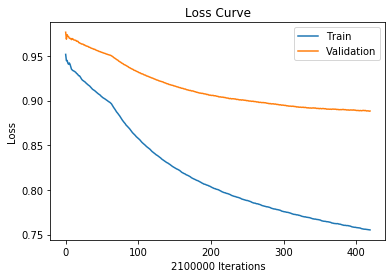

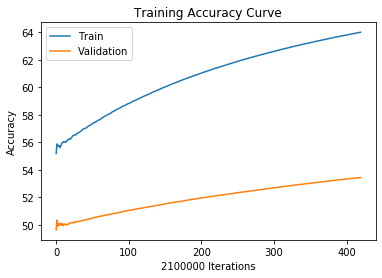

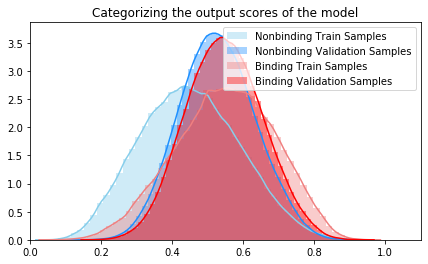

 49%|████▊     | 33509/68883 [13:10<11:49, 49.87it/s]

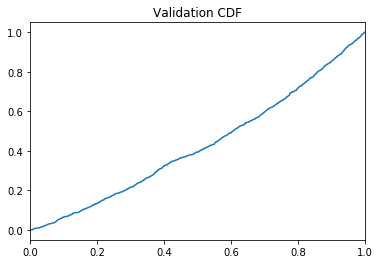

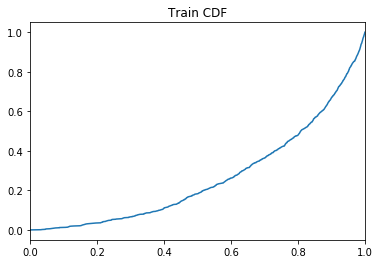

 49%|████▊     | 33516/68883 [14:02<146:40:47, 14.93s/it]

Training AUC at epoch 34: 0.2645715454545454
Validation AUC epoch 34: 0.42799518181818186
Training Accuracy at epoch 34: 64.0104761904762
Validation Accuracy epoch 34: 53.445142857142855


 56%|█████▌    | 38522/68883 [15:56<08:41, 58.22it/s]    

Train: Sensitivity: 0.6407175947280773 Specificity: 0.6397005153088199
Val: Sensitivity: 0.6589846182381854 Specificity: 0.4090140742959513


 63%|██████▎   | 43519/68883 [17:51<07:01, 60.16it/s]

Train: Sensitivity: 0.640826956740371 Specificity: 0.6398403431769435
Val: Sensitivity: 0.6589041975299318 Specificity: 0.40923885423665585


 70%|███████   | 48517/68883 [19:45<05:19, 63.84it/s]

Train: Sensitivity: 0.640948462312433 Specificity: 0.6399404446434661
Val: Sensitivity: 0.658784824290328 Specificity: 0.4094269598595621


 78%|███████▊  | 53521/68883 [21:38<07:53, 32.45it/s]

Train: Sensitivity: 0.6410389576052645 Specificity: 0.6400638279623404
Val: Sensitivity: 0.6587007915448279 Specificity: 0.4096454470368041


 85%|████████▍ | 58522/68883 [23:33<04:28, 38.65it/s]

Train: Sensitivity: 0.6411479917962902 Specificity: 0.6401564978482016
Val: Sensitivity: 0.6586078532652255 Specificity: 0.4098495736865928


 92%|█████████▏| 63519/68883 [25:27<02:00, 44.33it/s]

Train: Sensitivity: 0.6412434078013285 Specificity: 0.6402758587049612
Val: Sensitivity: 0.6585530770353024 Specificity: 0.41004823120811823


 99%|█████████▉| 68517/68883 [27:19<00:07, 49.92it/s]

Train: Sensitivity: 0.6412922391385072 Specificity: 0.6403751923127314
Val: Sensitivity: 0.6584419849707122 Specificity: 0.4102505017747873


  0%|          | 6/68883 [00:00<19:44, 58.17it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 35  with learning rate:  [2.657205000000001e-05]


  7%|▋         | 4637/68883 [01:45<19:11, 55.78it/s]

Train: Sensitivity: 0.6413837233451394 Specificity: 0.6404368390880792
Val: Sensitivity: 0.6583034836614936 Specificity: 0.41049029395868364


 14%|█▍        | 9638/68883 [03:41<17:02, 57.92it/s]

Train: Sensitivity: 0.6415097333354489 Specificity: 0.6405387959339741
Val: Sensitivity: 0.6582514408191542 Specificity: 0.4106903130739893


 21%|██        | 14622/68883 [05:35<15:56, 56.73it/s]

Train: Sensitivity: 0.6415716443287354 Specificity: 0.6406413504305594
Val: Sensitivity: 0.6581222713897104 Specificity: 0.4108766634039914


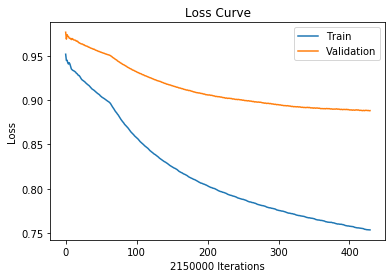

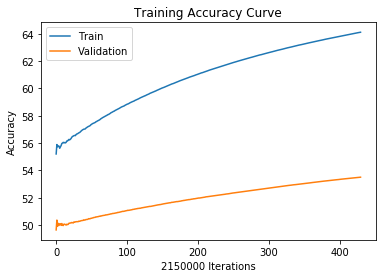

 21%|██        | 14622/68883 [05:50<15:56, 56.73it/s]

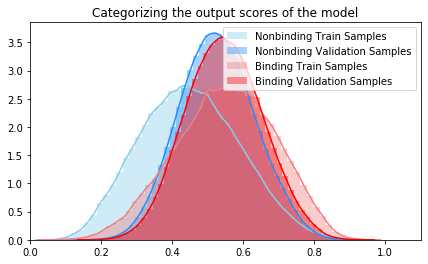

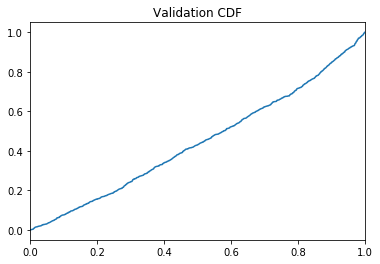

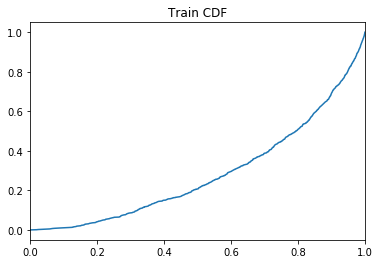

 21%|██        | 14634/68883 [06:48<45:56:36,  3.05s/it]

Training AUC at epoch 35: 0.28367881818181817
Validation AUC epoch 35: 0.44336254545454545
Training Accuracy at epoch 35: 64.11060465116279
Validation Accuracy epoch 35: 53.49944186046512


 29%|██▊       | 19632/68883 [08:48<15:07, 54.30it/s]   

Train: Sensitivity: 0.6416900618152158 Specificity: 0.6407415030698168
Val: Sensitivity: 0.6580568170578736 Specificity: 0.41109621246075906


 36%|███▌      | 24635/68883 [10:55<24:57, 29.55it/s]

Train: Sensitivity: 0.6417823156868361 Specificity: 0.6408612056916683
Val: Sensitivity: 0.6579539061707446 Specificity: 0.4112969349905642


 43%|████▎     | 29637/68883 [13:00<18:34, 35.22it/s]

Train: Sensitivity: 0.6418961220309516 Specificity: 0.6409390615843896
Val: Sensitivity: 0.6578558264625157 Specificity: 0.41151798856752775


 50%|█████     | 34633/68883 [15:05<14:59, 38.07it/s]

Train: Sensitivity: 0.641989124598446 Specificity: 0.6410311890586933
Val: Sensitivity: 0.6577343795899183 Specificity: 0.4117323181474956


 58%|█████▊    | 39635/68883 [17:10<10:29, 46.50it/s]

Train: Sensitivity: 0.6420900707189623 Specificity: 0.6411301990562077
Val: Sensitivity: 0.6576208409961826 Specificity: 0.4119458764790168


 65%|██████▍   | 44639/68883 [19:13<07:51, 51.46it/s]

Train: Sensitivity: 0.6421886837501665 Specificity: 0.6412819020471388
Val: Sensitivity: 0.6575428708752173 Specificity: 0.41216865372339395


 72%|███████▏  | 49637/68883 [21:16<06:06, 52.44it/s]

Train: Sensitivity: 0.6422976668758675 Specificity: 0.6413718685559351
Val: Sensitivity: 0.6574203735713922 Specificity: 0.412355899305964


 79%|███████▉  | 54635/68883 [23:21<04:12, 56.38it/s]

Train: Sensitivity: 0.6423724103636643 Specificity: 0.6414759165857682
Val: Sensitivity: 0.6573382111632206 Specificity: 0.412575967078793


 87%|████████▋ | 59629/68883 [25:25<02:49, 54.62it/s]

Train: Sensitivity: 0.6424992954451555 Specificity: 0.6415744932243304
Val: Sensitivity: 0.6572543282568902 Specificity: 0.4127770870898068


 94%|█████████▍| 64621/68883 [27:29<01:16, 55.84it/s]

Train: Sensitivity: 0.6425790118816981 Specificity: 0.6416882287711281
Val: Sensitivity: 0.6571689345565572 Specificity: 0.41295787863409505


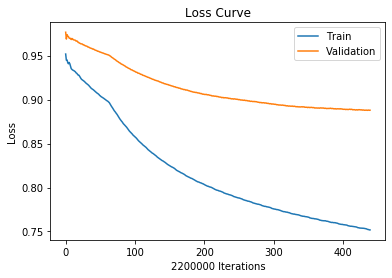

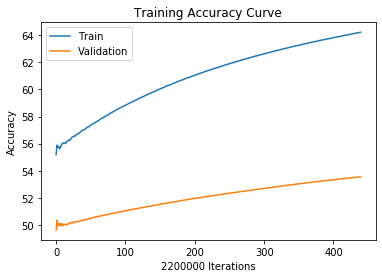

 94%|█████████▍| 64621/68883 [27:40<01:16, 55.84it/s]

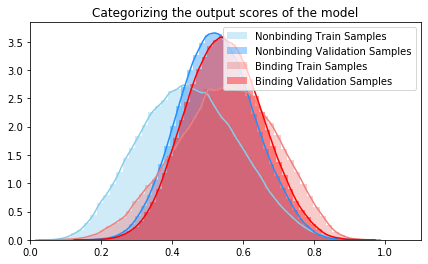

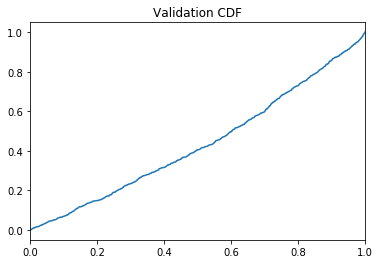

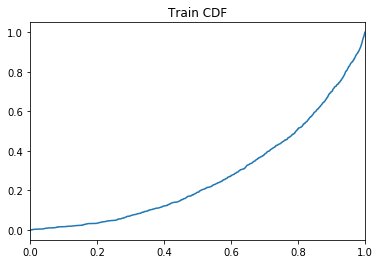

 94%|█████████▍| 64633/68883 [28:46<3:12:35,  2.72s/it]

Training AUC at epoch 35: 0.27532281818181825
Validation AUC epoch 35: 0.4356788181818182
Training Accuracy at epoch 35: 64.21331818181818
Validation Accuracy epoch 35: 53.55522727272727


  0%|          | 6/68883 [00:00<19:22, 59.23it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 36  with learning rate:  [2.657205000000001e-05]


  1%|          | 754/68883 [00:18<32:18, 35.14it/s]

Train: Sensitivity: 0.6426330153784136 Specificity: 0.6417787104946964
Val: Sensitivity: 0.6570875168711684 Specificity: 0.4131394558876295


  8%|▊         | 5754/68883 [02:23<26:08, 40.25it/s]

Train: Sensitivity: 0.6427230110741219 Specificity: 0.6418416472662342
Val: Sensitivity: 0.6569753292290497 Specificity: 0.4133555638339436


 16%|█▌        | 10757/68883 [04:23<18:50, 51.40it/s]

Train: Sensitivity: 0.642837904524675 Specificity: 0.6419403957141491
Val: Sensitivity: 0.6569261733377939 Specificity: 0.41356555132886813


 23%|██▎       | 15755/68883 [06:19<16:12, 54.61it/s]

Train: Sensitivity: 0.6428883193524358 Specificity: 0.6420458534109257
Val: Sensitivity: 0.6567987287013964 Specificity: 0.41373833271976185


 30%|███       | 20753/68883 [08:14<13:43, 58.46it/s]

Train: Sensitivity: 0.6430021963032644 Specificity: 0.64214291294708
Val: Sensitivity: 0.6567132910332775 Specificity: 0.4139617114251136


 37%|███▋      | 25751/68883 [10:08<12:29, 57.58it/s]

Train: Sensitivity: 0.643117693690976 Specificity: 0.6422455384620898
Val: Sensitivity: 0.6566226907743526 Specificity: 0.4141463076406342


 45%|████▍     | 30749/68883 [12:05<10:53, 58.38it/s]

Train: Sensitivity: 0.64321282593565 Specificity: 0.6423129218861883
Val: Sensitivity: 0.6565053548764315 Specificity: 0.41436544501865175


 52%|█████▏    | 35755/68883 [14:01<16:56, 32.59it/s]

Train: Sensitivity: 0.6433022308022308 Specificity: 0.6424174040245468
Val: Sensitivity: 0.6563894790292905 Specificity: 0.41456724007017465


 59%|█████▉    | 40752/68883 [15:55<12:28, 37.60it/s]

Train: Sensitivity: 0.6433946078212809 Specificity: 0.6425260635921388
Val: Sensitivity: 0.6562834964826475 Specificity: 0.4147668727460072


 66%|██████▋   | 45740/68883 [17:52<11:57, 32.24it/s]

Train: Sensitivity: 0.6435009755676576 Specificity: 0.6426438160667615
Val: Sensitivity: 0.6562014450398798 Specificity: 0.4149824941252908


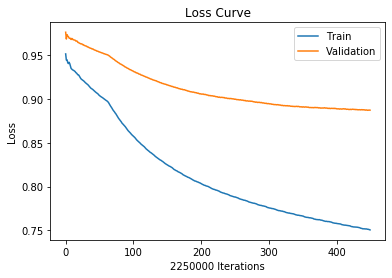

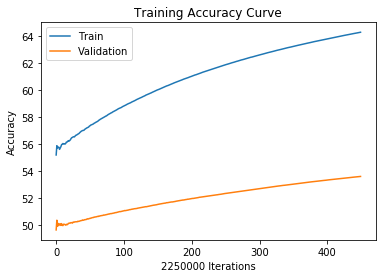

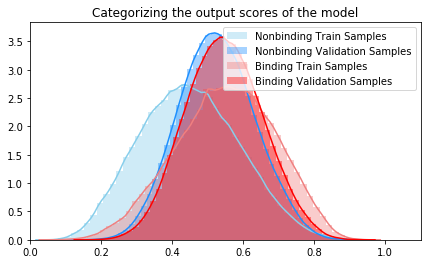

 66%|██████▋   | 45740/68883 [18:10<11:57, 32.24it/s]

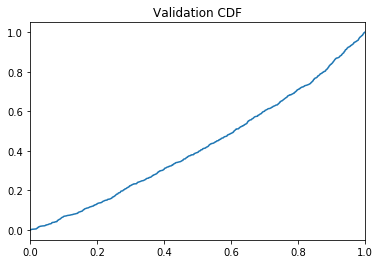

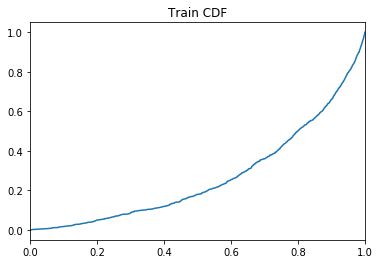

 66%|██████▋   | 45751/68883 [19:03<24:16:42,  3.78s/it]

Training AUC at epoch 36: 0.26758427272727275
Validation AUC epoch 36: 0.4236438181818182
Training Accuracy at epoch 36: 64.3072
Validation Accuracy epoch 36: 53.607644444444446


 74%|███████▎  | 50756/68883 [20:58<05:40, 53.26it/s]   

Train: Sensitivity: 0.6436081908620718 Specificity: 0.6427473962717554
Val: Sensitivity: 0.6560965418669342 Specificity: 0.4151551283957851


 81%|████████  | 55754/68883 [22:53<04:00, 54.68it/s]

Train: Sensitivity: 0.643683587674014 Specificity: 0.64283314531045
Val: Sensitivity: 0.6559699256073053 Specificity: 0.4153952091552049


 88%|████████▊ | 60751/68883 [24:50<02:27, 55.14it/s]

Train: Sensitivity: 0.6437976346098945 Specificity: 0.6429228626297966
Val: Sensitivity: 0.6559134394672549 Specificity: 0.4155846113200455


 95%|█████████▌| 65755/68883 [26:44<00:51, 60.45it/s]

Train: Sensitivity: 0.6438597063707856 Specificity: 0.643041542230097
Val: Sensitivity: 0.6557923289628295 Specificity: 0.41575207414281


  0%|          | 7/68883 [00:00<17:55, 64.03it/s]

Saving to:  model_checkpoints/binary/ResnetSeparated/08122020_2.pth
Starting epoch: 37  with learning rate:  [2.657205000000001e-05]


  3%|▎         | 1868/68883 [00:42<18:30, 60.35it/s]

Train: Sensitivity: 0.6439306673753517 Specificity: 0.6431075079284364
Val: Sensitivity: 0.6557226615857716 Specificity: 0.41597819486223503


 10%|▉         | 6869/68883 [02:39<32:11, 32.11it/s]

Train: Sensitivity: 0.6440308441216345 Specificity: 0.6431857696702865
Val: Sensitivity: 0.6556163459589429 Specificity: 0.41618550563301887


 17%|█▋        | 11874/68883 [04:34<21:44, 43.69it/s]

Train: Sensitivity: 0.6441236332986666 Specificity: 0.6432995207479165
Val: Sensitivity: 0.6555503733376341 Specificity: 0.41638171568175125


 24%|██▍       | 16872/68883 [06:28<20:04, 43.17it/s]

Train: Sensitivity: 0.6442007680962909 Specificity: 0.6433939167618418
Val: Sensitivity: 0.6554501454439171 Specificity: 0.4165567652505752


 32%|███▏      | 21872/68883 [08:25<15:13, 51.47it/s]

Train: Sensitivity: 0.6442735879258292 Specificity: 0.6434814329207509
Val: Sensitivity: 0.6553396372827629 Specificity: 0.4167753067149174


 39%|███▉      | 26860/68883 [10:20<14:17, 49.03it/s]

Train: Sensitivity: 0.6443843052325177 Specificity: 0.6435773950993064
Val: Sensitivity: 0.6552523022586515 Specificity: 0.41698905072845266


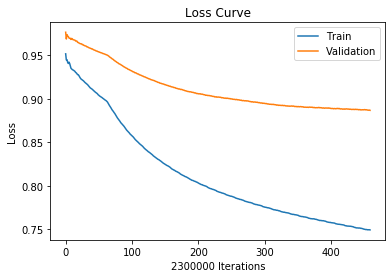

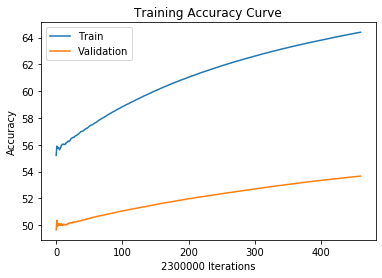

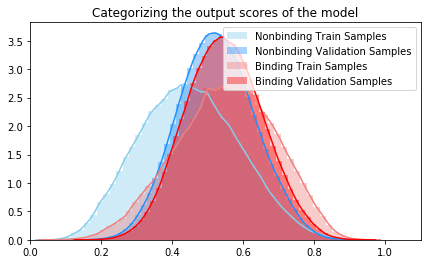

 39%|███▉      | 26860/68883 [10:40<14:17, 49.03it/s]

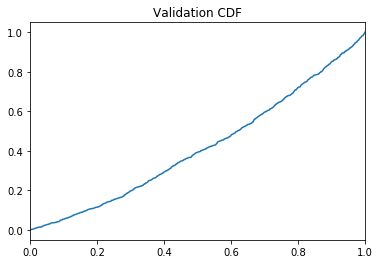

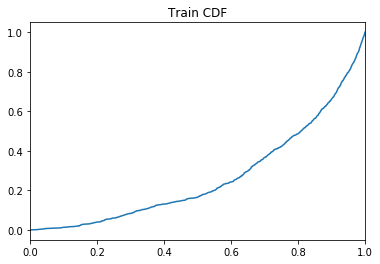

 39%|███▉      | 26867/68883 [11:32<174:14:51, 14.93s/it]

Training AUC at epoch 37: 0.2656890909090909
Validation AUC epoch 37: 0.41731563636363633
Training Accuracy at epoch 37: 64.39804347826087
Validation Accuracy epoch 37: 53.66


 41%|████      | 27922/68883 [11:56<25:19, 26.96it/s]    

In [ ]:
model=ResNetSeparated(BasicBlock, [2, 1, 1, 1], num_classes=2)
model_name = model.name
model_id = "08122020_2"
model.to(device)
checkpoint = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
NUM_EPOCHS = 50
BATCH_SIZE = 64
gamma = 5e-5
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, model.single_alphabet, checkpoint, save_path)